# Data understanding
For understanding the dataset we follow some precise steps:
- Collecting the data
- Describe the data
- Do an exploration of this data
- And finally, some verifications

Before doing this, we will summarize the information we already have about this dataset.

Context and Origin
----
This dataset is a collection of medical records focused on the early detection of Chronic Kidney Disease (CKD) in an Indian population. It was compiled in July 2015 through a collaboration between the Department of Computer Science at Alagappa University and Apollo Hospitals in Tamil Nadu, India. The involvement of a Senior Consultant Nephrologist (Dr. P. Soundarapandian) suggests the data has strong clinical validity.

Dataset Structure & Target
----
It contains 400 patient instances. It is a **binary classification** problem. The target variable is `status`, identifying whether a patient has chronic kidney disease (CKD) or not.
Also, there is a moderate imbalance in the target classes; about 250 are CKD cases, while the rest are control ones.

Feature Space
----
The data is high-dimensional with **24 predictive attributes** (plus the target class). The features are a mix of data types:
- Numerical are 11 features: continuous variables including Age, Blood pressure, and various blood chemistry levels (as blood urea, hemoglobin, sodium, etc.)
- Categorical are 14 features: discrete categories including specific gravity, presence of Bacteria/Pus, symptoms as hypertension, diabetes, etc.


Data quality & Preprocessing Needs
----

The documentation explicitly flags that **missing values** are shown as '?'. So we will have to have this in consideration.

Also, we will need to homogenize the categorical features. Some of them are as 'Yes/No', others as 'Normal/Abnormal', ... So converting these categorical values to binary formats, for example, will be an important step. Furthermore, some nominal features as **specific gravity, albumin and sugar** behave like ordinal data because the order is important, so it is needed to preserve the order.



# Environment Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy.stats.contingency import association 
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Visualization Config
plt.style.use('ggplot')
sns.set_context('notebook')
pd.set_option('display.max_columns', None)

# Path Config
DATA_PATH = Path('../../data/raw/chronic_kindey_disease.csv')


# Phase 1: Data loading
Before analyzing what the data says, we must verify what the data is. So, we load raw data and defining custom null identifiers.

In [2]:
try:
    df = pd.read_csv(DATA_PATH, na_values="?", skipinitialspace=True)
    print(f"Data loaded successfully. Shape: {df.shape}")
    print(df.head(5))
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}")


Data loaded successfully. Shape: (400, 25)
    age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr    bu   sc    sod  pot  hemo   pcv    wbcc  rbcc  htn   dm cad appet  \
0  121.0  36.0  1.2    NaN  NaN  15.4  44.0  7800.0   5.2  yes  yes  no  good   
1    NaN  18.0  0.8    NaN  NaN  11.3  38.0  6000.0   NaN   no   no  no  good   
2  423.0  53.0  1.8    NaN  NaN   9.6  31.0  7500.0   NaN   no  yes  no  poor   
3  117.0  56.0  3.8  111.0  2.5  11.2  32.0  6700.0   3.9  yes   no  no  poor   
4  106.0  26.0  1.4    NaN  NaN  11.6  35.0  7300.0   4.6   no   no  no  good   

    pe  ane s

# Phase 2: Data Structure

In [3]:
# Data Shape
print(f"Data Dimension: {df.shape[0]} rows, {df.shape[1]} columns")

# Data Types and Schema
df.info()

Data Dimension: 400 rows, 25 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  ap

Observations:
----
- Dimensions: 400 instances, 25 attributes.
- Types: The dataset contains a mix of numerical (float64) and categorical (object) features.

# Phase 3: Data cleaning a little bit

In [4]:
# Check for unique values in categorical columns to spot dirty data
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")



rbc: [nan 'normal' 'abnormal']
pc: ['normal' 'abnormal' nan]
pcc: ['notpresent' 'present' nan]
ba: ['notpresent' 'present' nan]
htn: ['yes' 'no' nan]
dm: ['yes' 'no' '\tno' nan]
cad: ['no' 'yes' nan]
appet: ['good' 'poor' nan]
pe: ['no' 'yes' nan]
ane: ['no' 'yes' nan]
status: ['ckd' 'ckd\t' 'notckd']


In [5]:
# Cleaning: Removing potential whitespace (e.g., '\tno', ' yes')
# We found specific issues in 'dm', 'cad', and 'status' columns
cols_to_clean = ['dm', 'status']

def clean_text(x):
    if isinstance(x, str):
        return x.strip().lower()
    return x

for col in cols_to_clean:
    df[col] = df[col].apply(clean_text)

# Verify Cleaning
print("\nPost-Cleaning Unique Values")
print(f"Status: {df['status'].unique()}")


Post-Cleaning Unique Values
Status: ['ckd' 'notckd']


**Correction**
- Fixed `dm` which contained `\tno`
- Fixed `status` which contained `ckd\t`

# Phase 4: Analysing missing values

       Total  Percent
rbc      152    38.00
rbcc     131    32.75
wbcc     106    26.50
pot       88    22.00
sod       87    21.75
pcv       71    17.75
pc        65    16.25
hemo      52    13.00
su        49    12.25
sg        47    11.75
al        46    11.50
bgr       44    11.00
bu        19     4.75
sc        17     4.25
bp        12     3.00
age        9     2.25
pcc        4     1.00
ba         4     1.00
htn        2     0.50
dm         2     0.50
cad        2     0.50
appet      1     0.25
pe         1     0.25
ane        1     0.25


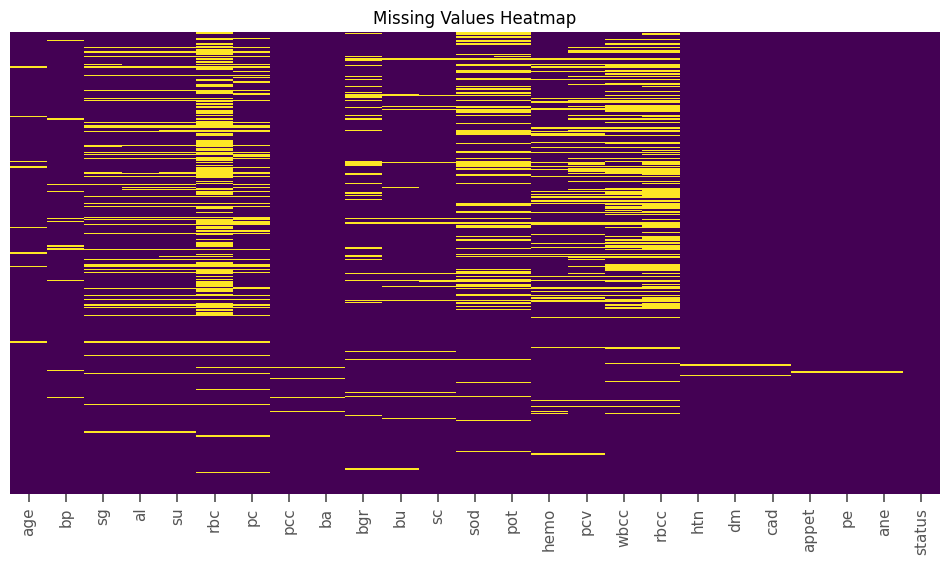

In [6]:
# Calculate missing values
missing_count = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_data = pd.concat([missing_count, missing_percent], axis=1, keys=['Total', 'Percent'])
print(missing_data[missing_data['Total'] > 0])

# Visualizing Missing Data Pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

Some **observations**:
- The features *rbc* (Red Blood Cells) and *rbcc* (Red blood cell count) have significant missing data.
- The heatmap suggests that missing values often occur across multiple columns for the same patients.

# Phase 5: Statistical Summary

In [7]:
# Numerical Summary
print(df.describe().T)

      count         mean          std       min      25%      50%      75%  \
age   391.0    51.483376    17.169714     2.000    42.00    55.00    64.50   
bp    388.0    76.469072    13.683637    50.000    70.00    80.00    80.00   
sg    353.0     1.017408     0.005717     1.005     1.01     1.02     1.02   
al    354.0     1.016949     1.352679     0.000     0.00     0.00     2.00   
su    351.0     0.450142     1.099191     0.000     0.00     0.00     0.00   
bgr   356.0   148.036517    79.281714    22.000    99.00   121.00   163.00   
bu    381.0    57.425722    50.503006     1.500    27.00    42.00    66.00   
sc    383.0     3.072454     5.741126     0.400     0.90     1.30     2.80   
sod   313.0   137.528754    10.408752     4.500   135.00   138.00   142.00   
pot   312.0     4.627244     3.193904     2.500     3.80     4.40     4.90   
hemo  348.0    12.526437     2.912587     3.100    10.30    12.65    15.00   
pcv   329.0    38.884498     8.990105     9.000    32.00    40.0

In [8]:
# Categorical Summary
print(df.describe(include=['object']).T)

       count unique         top freq
rbc      248      2      normal  201
pc       335      2      normal  259
pcc      396      2  notpresent  354
ba       396      2  notpresent  374
htn      398      2          no  251
dm       398      2          no  261
cad      398      2          no  364
appet    399      2        good  317
pe       399      2          no  323
ane      399      2          no  339
status   400      2         ckd  250


From these statistical summarizes we can deduce some important aspects.
For example: the *age* range from 2 to 90 years, with a mean of 51 years old, the *rbc* value tends to be normal, etc.

# Phase 6: Univariate Analysis
We will visualize the distribution of individual key variables

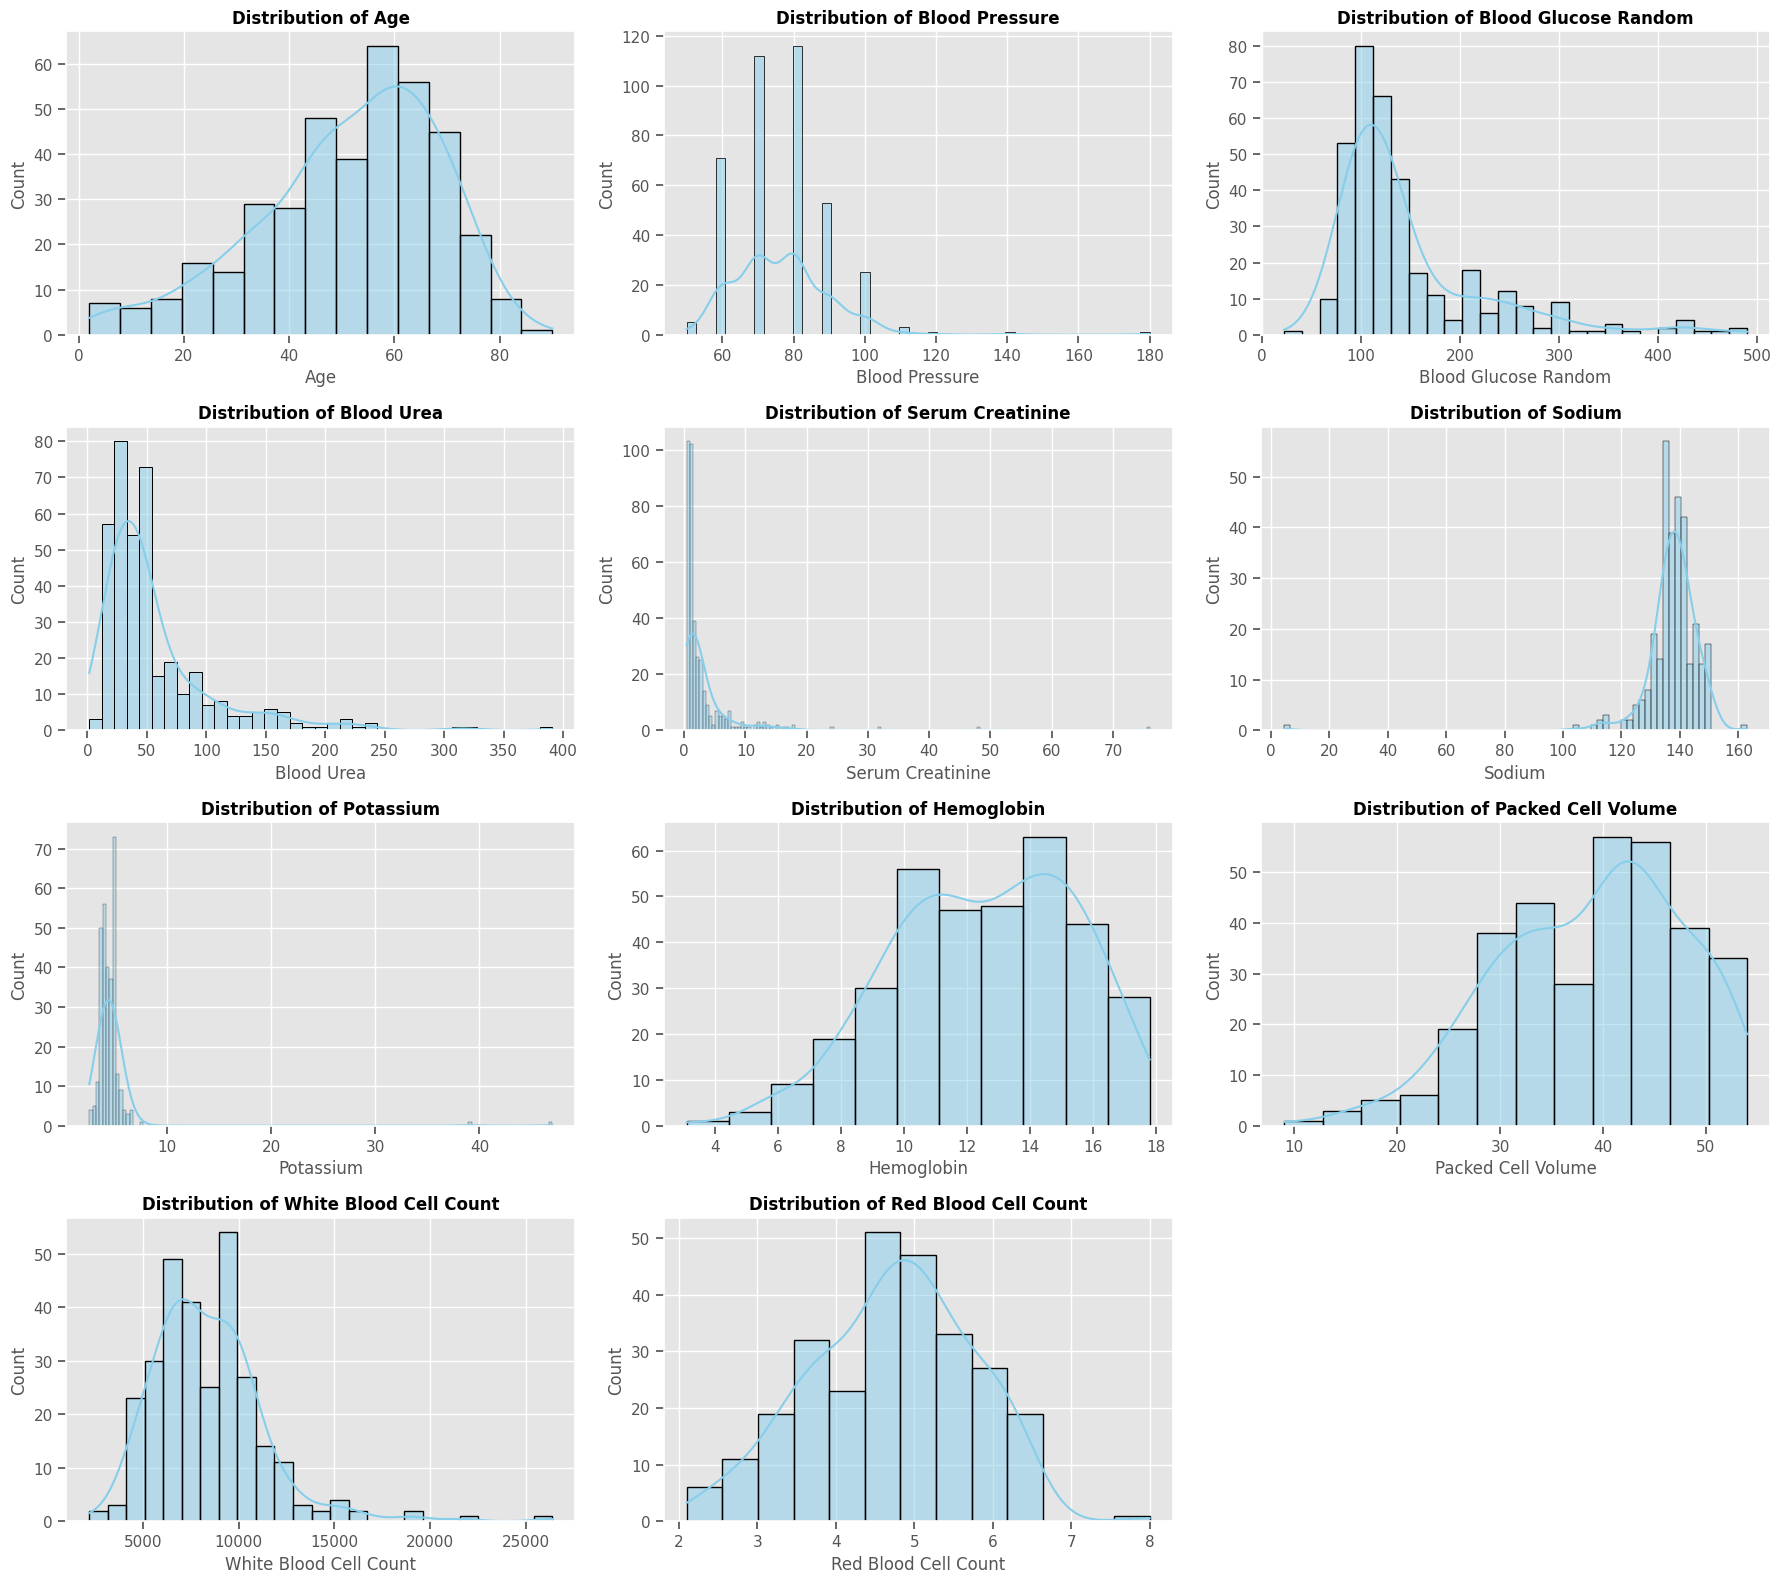

In [9]:
# Dictionary mapping column names to full names based on dataset documentation
numeric_cols_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count'
}

# Setup the plotting grid (4 rows x 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    # Plot histogram with KDE
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='skyblue', edgecolor='black')

    # Set titles and labels using the full name
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


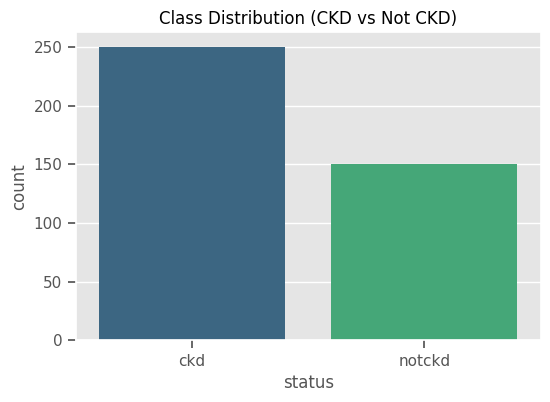

In [10]:
# Plotting Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=df, palette='viridis', hue='status')
plt.title('Class Distribution (CKD vs Not CKD)')
plt.show()

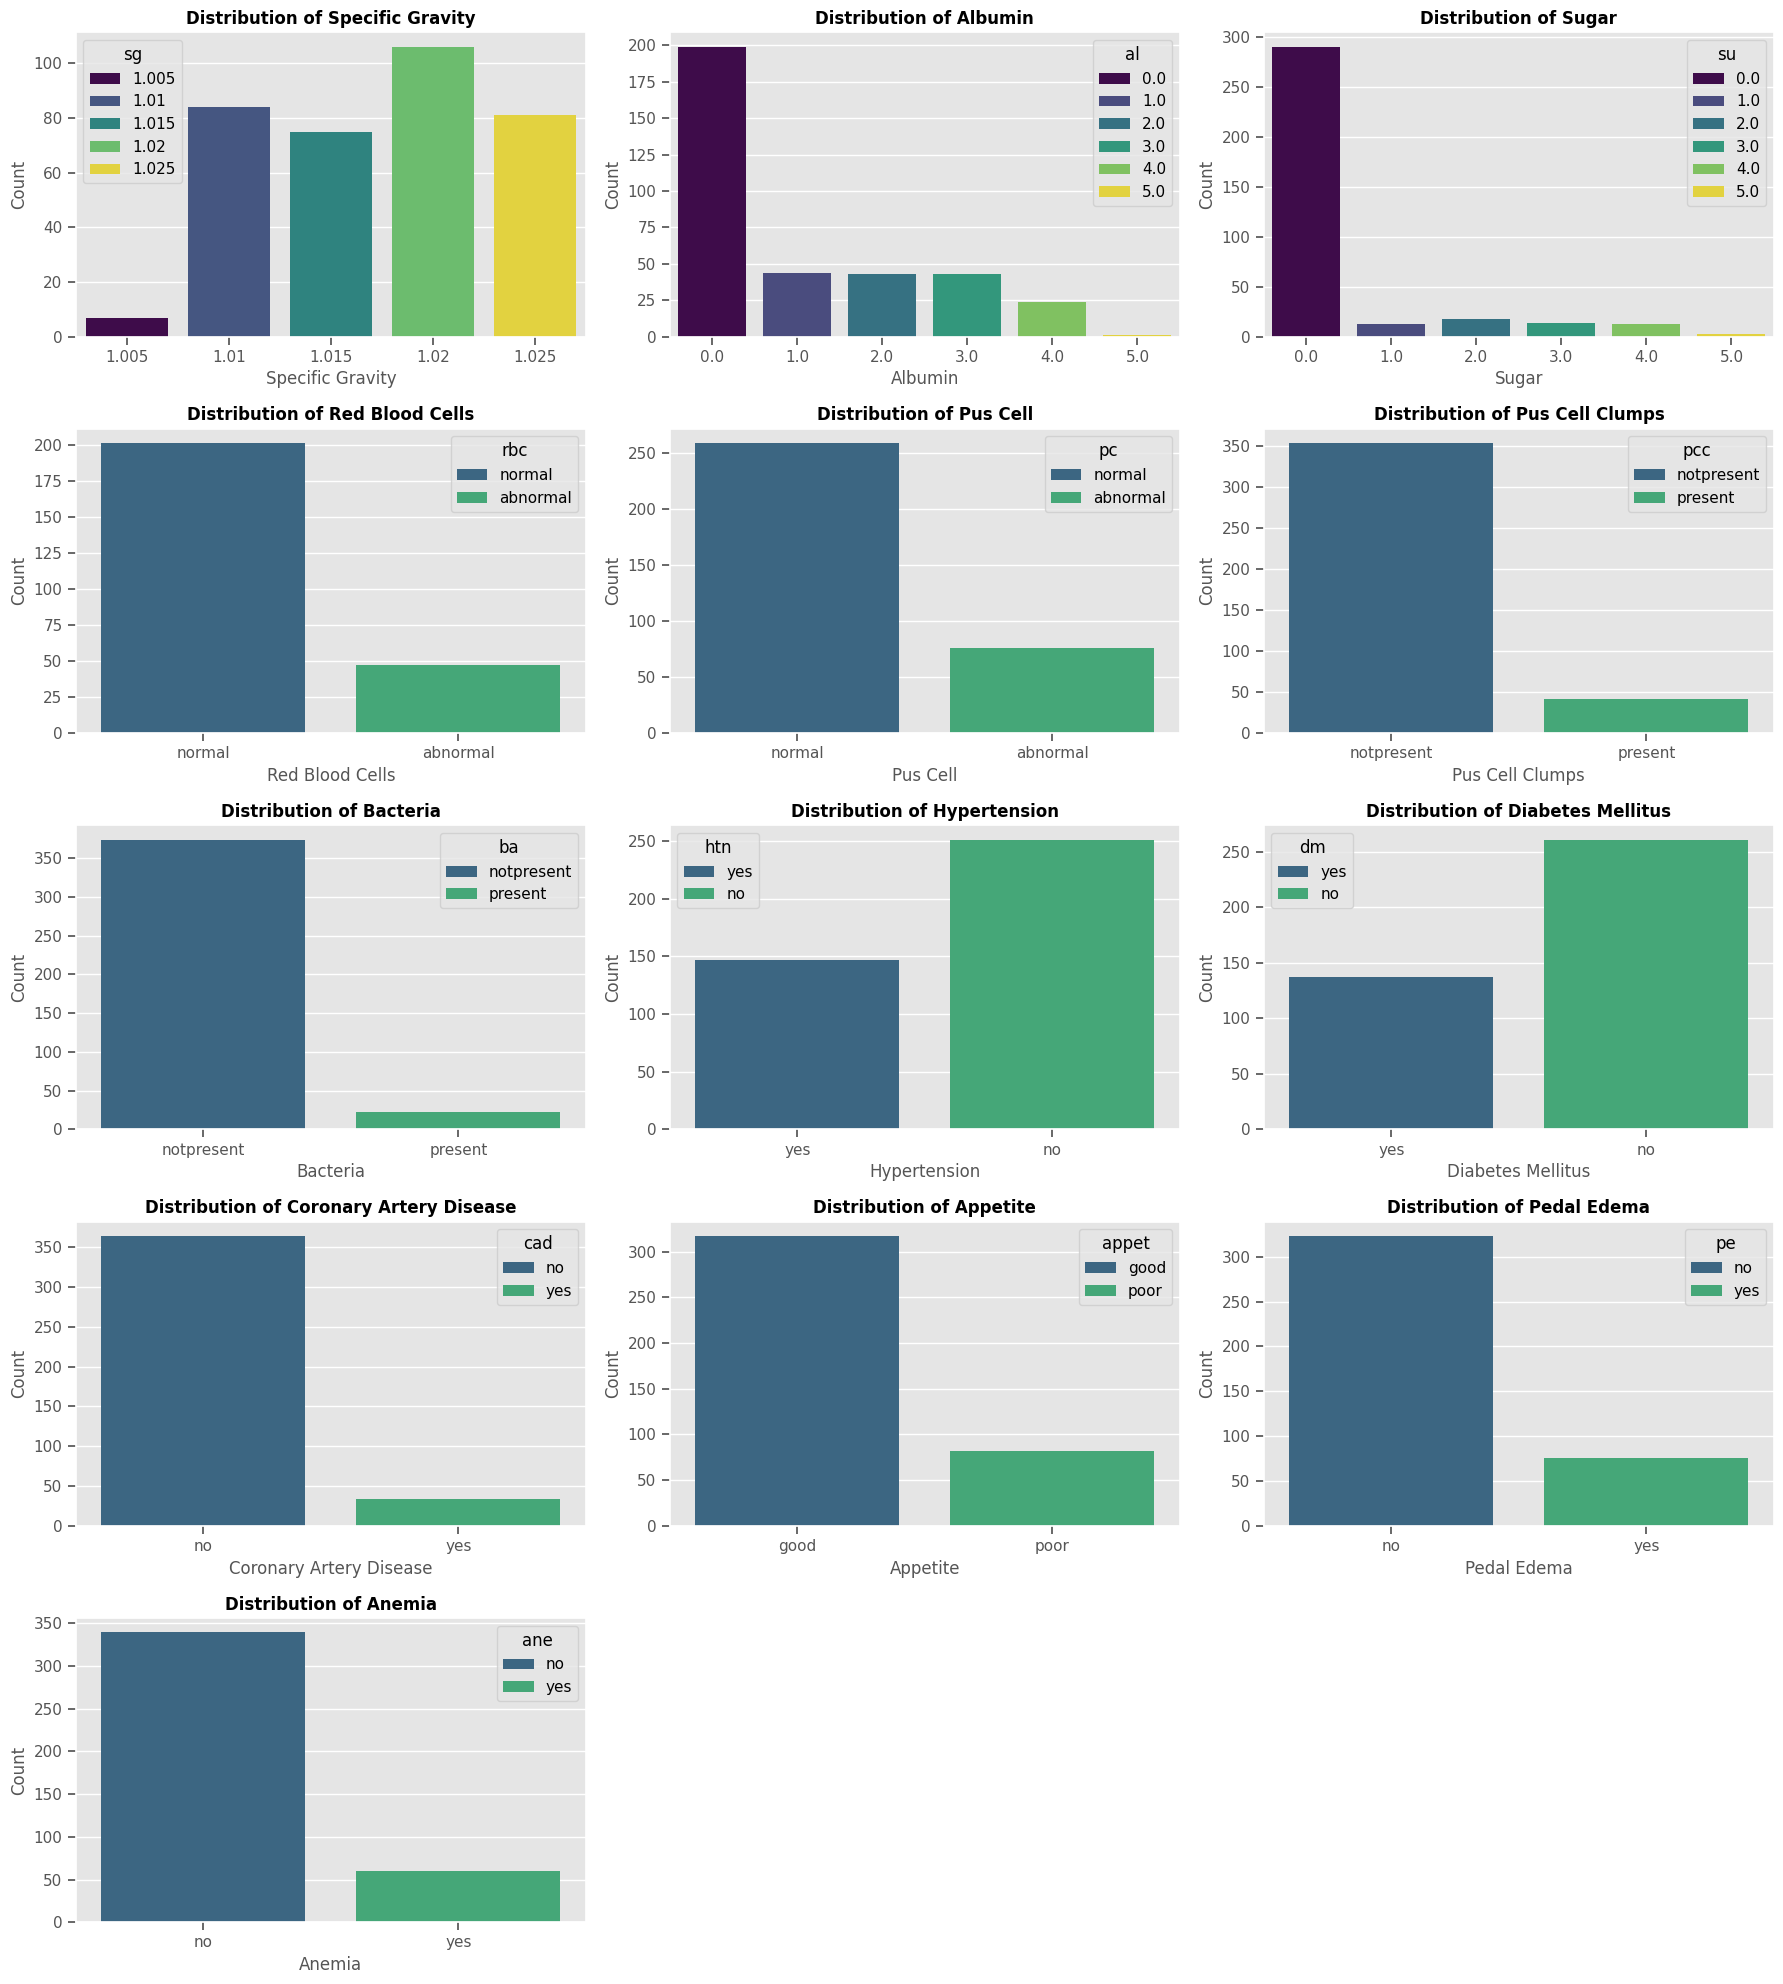

In [11]:
# Dictionary mapping categorical columns to full names
categorical_cols_mapping = {
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'pc': 'Pus Cell',
    'pcc': 'Pus Cell Clumps',
    'ba': 'Bacteria',
    'htn': 'Hypertension',
    'dm': 'Diabetes Mellitus',
    'cad': 'Coronary Artery Disease',
    'appet': 'Appetite',
    'pe': 'Pedal Edema',
    'ane': 'Anemia'
}

# Setup the plotting grid (5 rows x 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

for i, (col, full_name) in enumerate(categorical_cols_mapping.items()):
    # Sort order for ordinal variables (sg, al, su) to make the plot logical
    order = sorted(df[col].dropna().unique()) if col in ['sg', 'al', 'su'] else None

    # Create Count Plot
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order=order, hue= col)

    # Styling
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(len(categorical_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

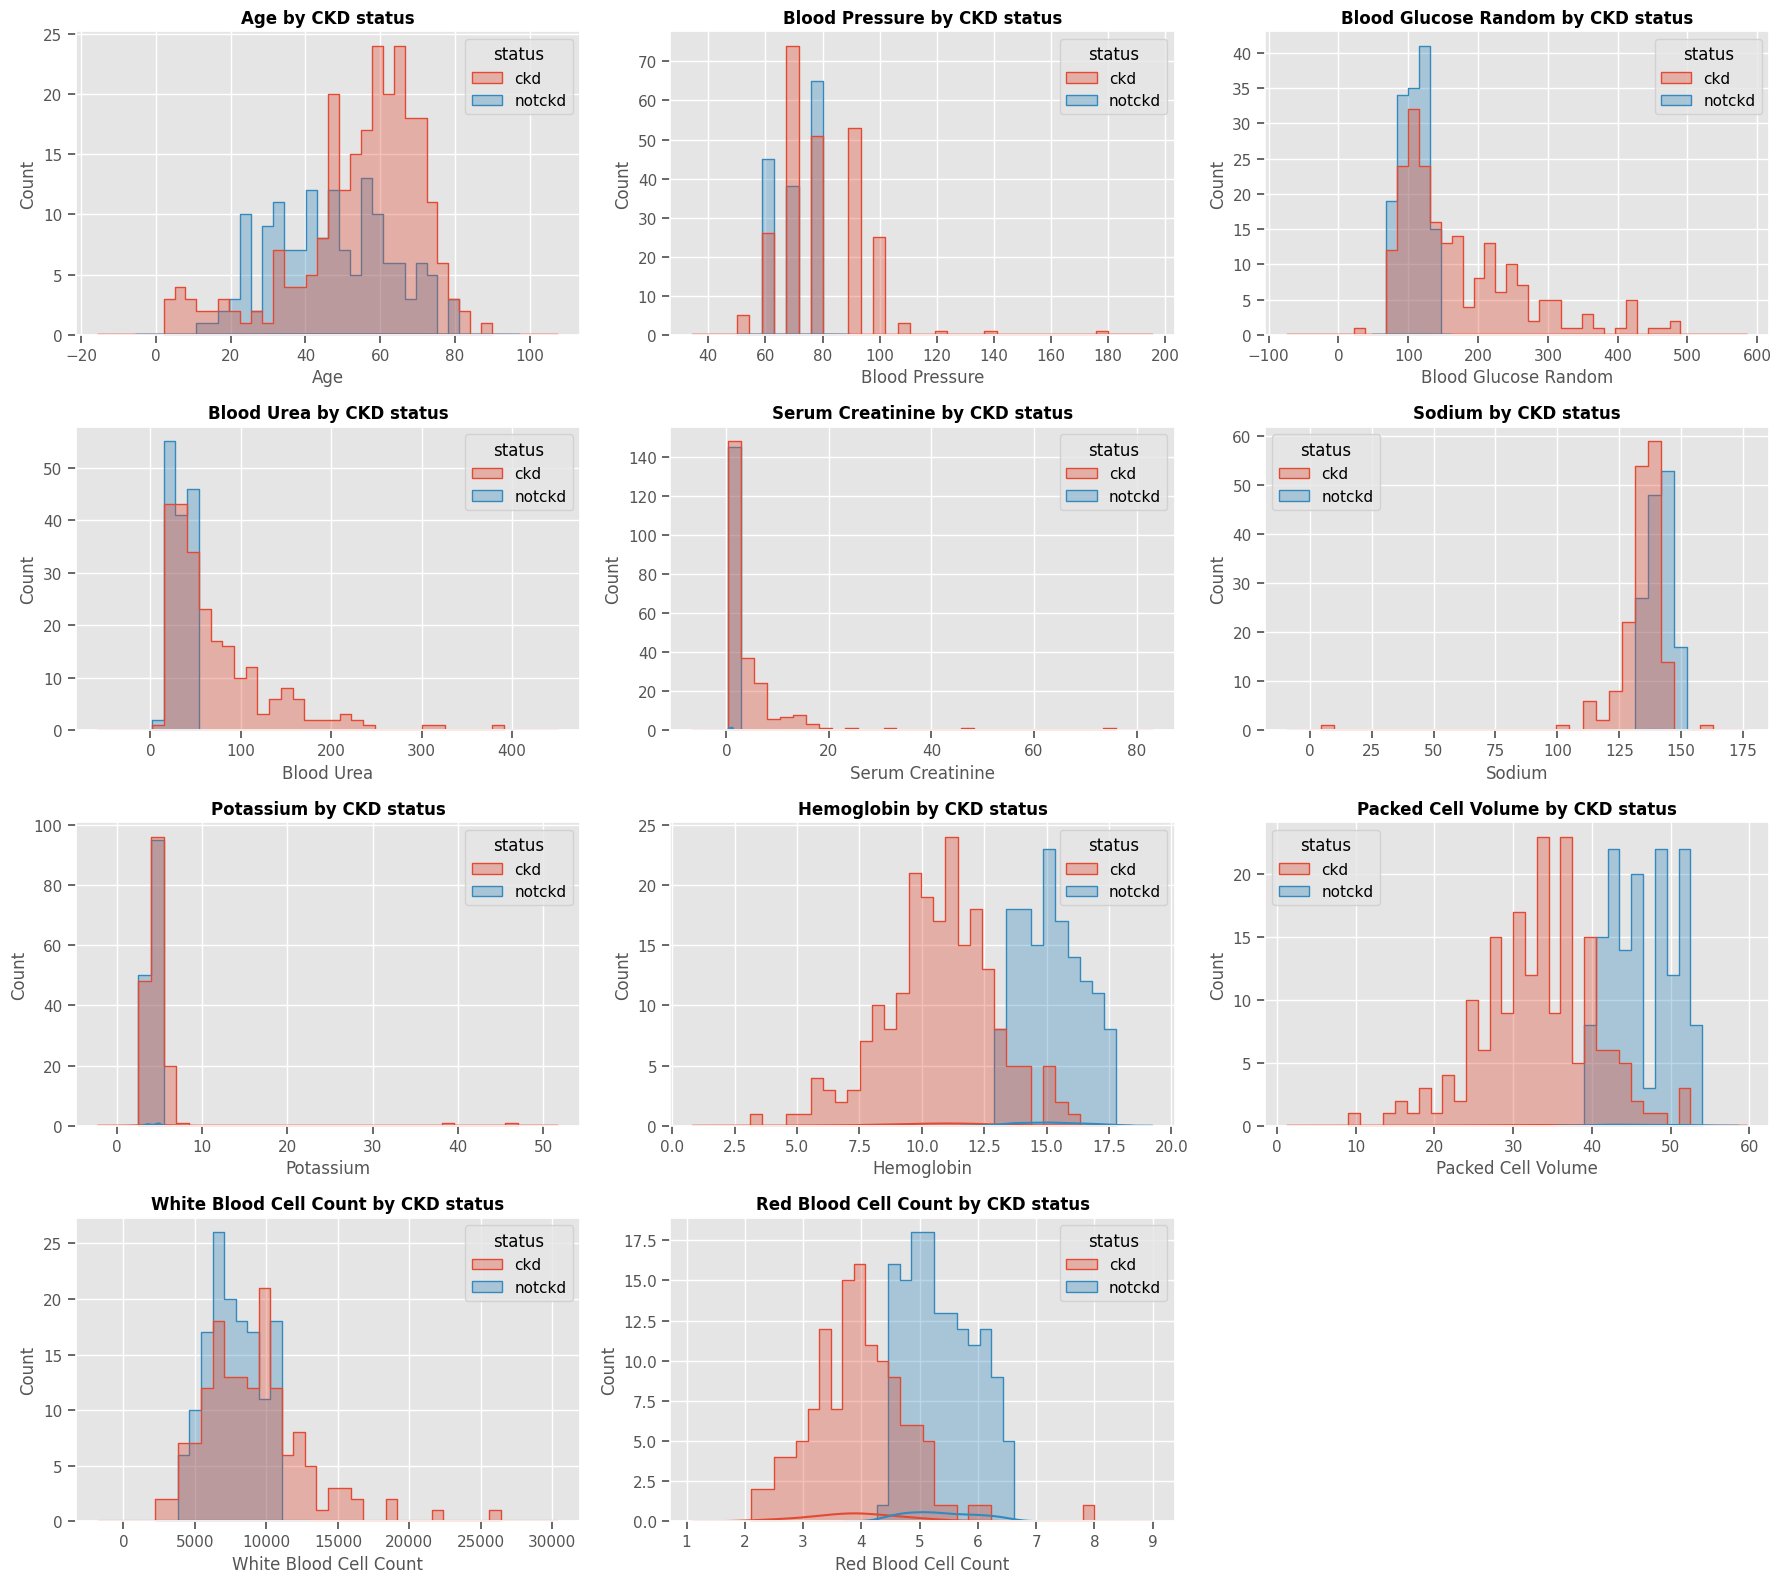

In [12]:

#Define which numeric columns to plot (same mapping you used)

numeric_cols_mapping = {
    "age":  "Age",
    "bp":   "Blood Pressure",
    "bgr":  "Blood Glucose Random",
    "bu":   "Blood Urea",
    "sc":   "Serum Creatinine",
    "sod":  "Sodium",
    "pot":  "Potassium",
    "hemo": "Hemoglobin",
    "pcv":  "Packed Cell Volume",
    "wbcc": "White Blood Cell Count",
    "rbcc": "Red Blood Cell Count",
}


# 2) Clean categorical text (fixes the '\tno' / 'ckd\t' problem) and standardize case
cat_cols = df.select_dtypes(include="object").columns
for c in cat_cols:
    df[c] = df[c].astype("string").str.strip().str.lower()

# Make sure status is only ckd / notckd (drop anything else if it exists)
df = df[df["status"].isin(["ckd", "notckd"])].copy()


#Ensure numeric columns are actually numeric (some may be read as strings)

num_cols = list(numeric_cols_mapping.keys())
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

#
#Plot distributions split by status (overlay hist + KDE per feature)
#
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    ax = axes[i]

    # Histogram overlay by class
    sns.histplot(
        data=df,
        x=col,
        hue="status",
        bins=30,
        stat="count",
        common_norm=False,   # keeps counts comparable within each status group
        element="step",
        alpha=0.35,
        ax=ax,
    )

    # KDE overlay by class (only if enough data; avoids warnings)
    # If you prefer no KDE at all, delete this block.
    for s in ["ckd", "notckd"]:
        x = df.loc[df["status"] == s, col].dropna()
        if len(x) >= 10 and x.nunique() > 1:
            sns.kdeplot(x=x, ax=ax)

    ax.set_title(f"{full_name} by CKD status", fontsize=12, fontweight="bold")
    ax.set_xlabel(full_name)
    ax.set_ylabel("Count")

#Remove unused subplot (there are 12 slots but 11 variables)
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Phase 7: Correlations

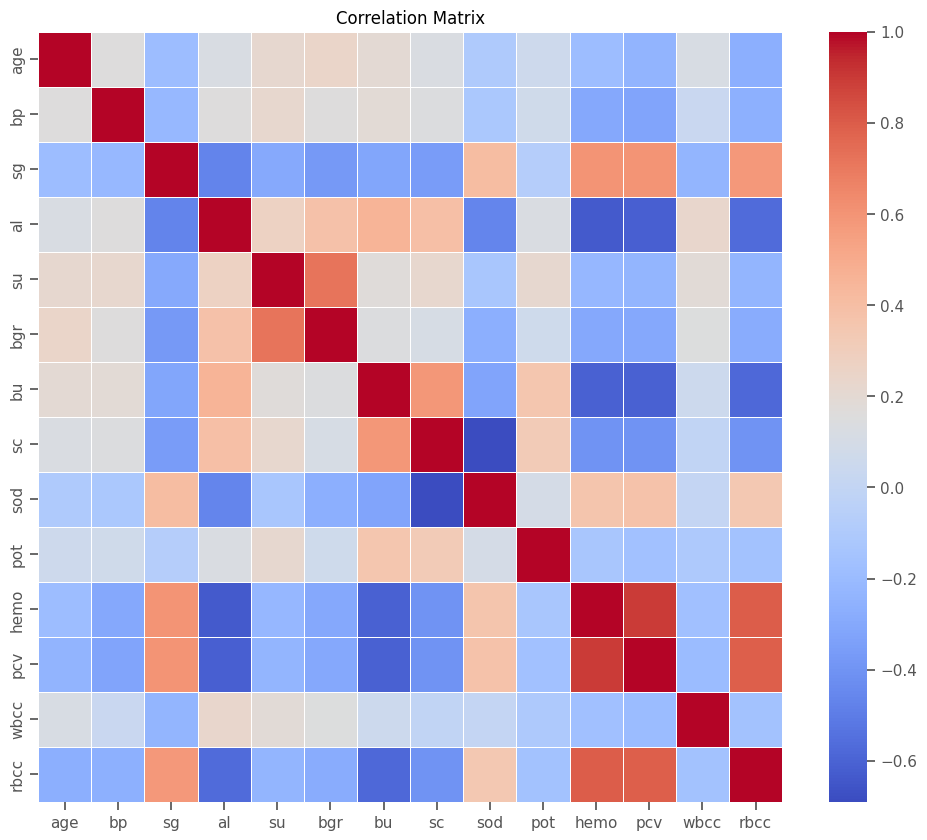

In [13]:
# Correlation Matrix
# Note: 'sg', 'al', 'su' are ordinal but encoded as float, so they appear here naturally.
plt.figure(figsize=(12, 10))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- *Hemoglobin (hemo)* and *PCV* have a strong positive correlation.
- *Serum Creatinine (sc)* and *Blood Urea (bu)* have a strong positive correlation too.
- *Specific Gravity (sg)* shows negative correlation with markers like *bu* and *sc*.

# DATA PREPARATION

## Missing values analysis


       Total  Percent
rbc      152    38.00
rbcc     131    32.75
wbcc     106    26.50
pot       88    22.00
sod       87    21.75
pcv       71    17.75
pc        65    16.25
hemo      52    13.00
su        49    12.25
sg        47    11.75
al        46    11.50
bgr       44    11.00
bu        19     4.75
sc        17     4.25
bp        12     3.00
age        9     2.25
pcc        4     1.00
ba         4     1.00
htn        2     0.50
dm         2     0.50
cad        2     0.50
appet      1     0.25
pe         1     0.25
ane        1     0.25


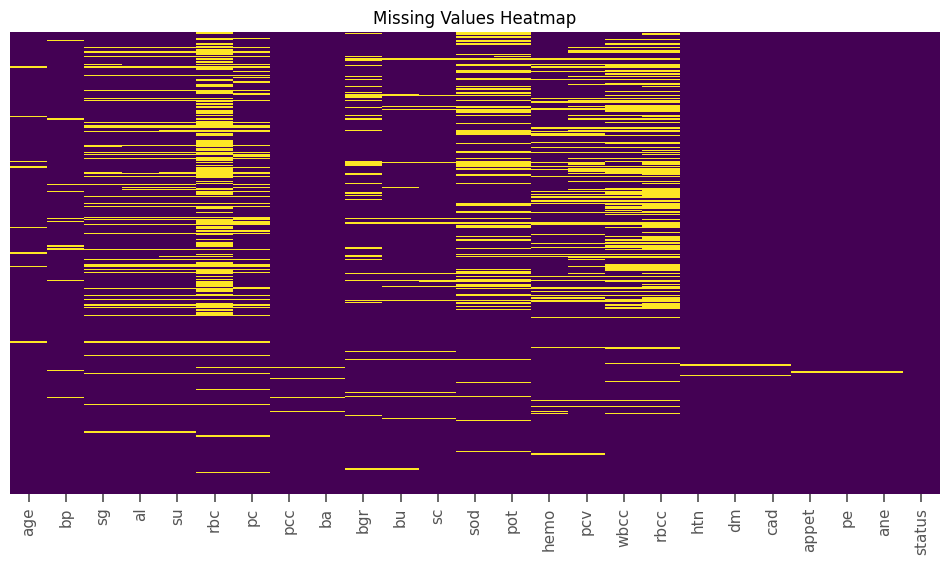

In [14]:
# Calculate missing values
missing_count = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_data = pd.concat([missing_count, missing_percent], axis=1, keys=['Total', 'Percent'])
print(missing_data[missing_data['Total'] > 0])

# Visualizing Missing Data Pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

We have 1012 missing values in total. Missingness affects 14 numeric and 10 categorical variables. Among the numeric features, the highest missing counts occur in 
- **red blood cell count (rbcc, 131)** 
- **white blood cell count (wbcc, 106)**
- **potassium (pot, 88)**
- **sodium (sod, 87)**
- **packed cell volume (pcv, 71)**
- **hemoglobin (hemo, 52)**
- **albumin (al, 46)**
- **random blood glucose (bgr, 44)**
- **blood urea (bu, 19)**
- **serum creatinine (sc, 17)**
- **blood pressure (bp, 12)**
- **age (age, 9)**

For categorical variables, missingness is mainly concentrated in 
- **red blood cells (rbc, 152)**
- **sugar (su, 49)**
- **specific gravity (sg, 47)**
- **pus cell (pc, 65)**
- **pus cell clumps (pcc, 4)**
- **bacteria (ba, 4)**
- **hypertension (htn, 2)**
- **diabetes mellitus (dm, 2)**
- **coronary artery disease (cad, 2)**
- **appetite (appet, 1)**
- **pedal edema (pe, 1)**
- **anemia (ane, 1)**.


####  **Check if missingness is predictive**

For each feature, we tested whether being missing is associated with the class (CKD vs not CKD).

In [15]:
# Missing % per column within each class
miss_by_class = (
    df.isna()
    .groupby(df["status"])
    .mean()
    .T * 100
)

# Keep only columns that have any missing values
miss_by_class = miss_by_class.loc[missing_data.index]

# Add a "gap" column (absolute difference between classes)
# (works even if order is not exactly ckd/notckd)
cols = miss_by_class.columns.tolist()
if len(cols) == 2:
    miss_by_class["gap_%"] = (miss_by_class[cols[0]] - miss_by_class[cols[1]]).abs()

miss_by_class.sort_values("gap_%" if "gap_%" in miss_by_class.columns else cols[0], ascending=False).head(20)


status,ckd,notckd,gap_%
rbc,57.2,6.000000,51.200000
rbcc,49.6,4.666667,44.933333
wbcc,39.6,4.666667,34.933333
pot,33.2,3.333333,29.866667
sod,32.8,3.333333,29.466667
pcv,26.8,2.666667,24.133333
pc,22.4,6.000000,16.400000
hemo,18.4,4.000000,14.400000
su,17.6,3.333333,14.266667
sg,16.8,3.333333,13.466667


From the previous table we can infer that missingness is not random. It is systematically higher in the CKD group for many variables. 

## Choose an imputation strategy

Imputation is the process of replacing missing entries (NaNs) with acceptable values so the dataset can be used for downstream analysis and modeling. Instead of deleting incomplete rows (which can shrink the dataset and introduce bias) we estimate missing values using other variables. The key idea is that missing data is rarely random in clinical datasets, many variables are clinically connected (e.g., hemoglobin and anemia). Therefore, we chose imputation strategies that respect medical relationships and preserve realistic combinations of values.


Before imputing we will examine the clinical structure of features.

## Clinical interpretation of variables

The attributes can be broadly interpreted as reflecting different components of routine clinical evaluation in patients with suspected renal disease.

- **Demographic and vital sign information** includes `age` and `blood pressure`, both of which are well-established risk factors for CKD progression. `Blood pressure` reflects both a potential cause and a consequence of impaired renal function.

- **Urinalysis variables** constitute a substantial portion of the dataset and include `specific gravity`, `albumin`, `sugar`, `red blood cells`, `pus cells clumps` and `bacteria`. These variables provide direct evidence of renal damage or urinary tract pathology. Although some of these attributes are encoded as nominal variables, several of them represent ordinal or semi-quantitative clinical scales.

- **Blood biochemistry markers** include `random blood glucose`, `blood urea`, `serum creatinine`, `sodium` and `potassium`. Among these, `serum creatinine`and `blood urea` are key indicators of renal function and are central to the clinical assessment of CKD. Electrolyte levels may reflect metabolic disturbances associated with reduced kidney function.

- **Hematological parameters** as `hemoglobin`, `packed cell volume`, `white blood cell count`and `red blood cell count` describe systemic effects of CKD such as anema or inflammation. Multiple variables capture related physiological processes reinforcing the clinical relevance of these features.

- **Comorbities and symptoms** as `hypertension`, `diabetes mellitus`, `coronary artery disease`, `appetite status`, `pedal edema`and `anemia`.

The **target variable** (`STATUS`) classifies individuals as having CKD or not.


The interpretation of variables was informed by standard clinical frameworks for CKD assessment, which integrate kidney function, markers of renal damage and systemic complications as describbed in international clinical guidelines (KDIGO).


Kidney Disease: Improving Global Outcomes (KDIGO) CKD Work Group. (2024). KDIGO 2024 Clinical Practice Guideline for the Evaluation and Management of Chronic Kidney Disease. Kidney International, 105(4S), S117–S314. https://doi.org/10.1016/j.kint.2023.10.018

In [16]:
# Clinical profiles grouping based on their physiological and diagnostic role in CKD.
# These profiles guide data preparation decisions (encoding, transformation, missing value handling) 
# and help identify potential sources of data leakage.
clinical_profiles = {
    "demographics": ["age", "bp"],
    "urinalysis": ["sg", "al", "su", "rbc", "pc", "pcc", "ba"],
    "renal_function": ["sc", "bu"],
    "electrolytes": ["sod", "pot"],
    "hematology": ["hemo", "pcv", "wc", "rbcc"],
    "diabetes": ["bgr", "dm", "su"], # `su` reflects glucosuria linked to diabetes and urinalysis
    "cardiovascular": ["htn", "cad", "pe"],
    "clinical_status": ["appet", "ane"]
}
print("\nClinical Profiles")
for profile, cols in clinical_profiles.items():
    print(f"{profile.capitalize()}: {cols}")



Clinical Profiles
Demographics: ['age', 'bp']
Urinalysis: ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba']
Renal_function: ['sc', 'bu']
Electrolytes: ['sod', 'pot']
Hematology: ['hemo', 'pcv', 'wc', 'rbcc']
Diabetes: ['bgr', 'dm', 'su']
Cardiovascular: ['htn', 'cad', 'pe']
Clinical_status: ['appet', 'ane']


### 1. The anemia Profile

Anemia is a common systemic complication kidney disease, primarly resulting from reduced erythropoietin production, impaired iron metabolism and chronic inflammation. As kidney function declines, the bone marrow’s ability to sustain adequate red blood cell production is progressively compromised, leading to reduced oxygen-carrying capacity.

The anemia profile includes the following variables:
- `hemo` which reflects the concentration of oxygen carrying protein in blood and serves as the primary quantitative marker of anemia severity.
- `pcv` (hematocrit) which represents the proportion of blood volume occupied by red blood cells and provides complementary information to hemoglobin levels.
- `rbcc` which quantifies the number of circulating erythrocytes and reflects bone marrow output.
- `ane` binary clinical variable indicating whether anemia has been diagnosed, integrating laboratory values and clinical judgment.

These variables are biologically and physiologically interrelated, as hemoglobin concentration, hematocrit, and red blood cell count jointly describe erythropoietic function and blood oxygen transport. Their inclusion enables the assessment of internal consistency within the anemia profile and supports clinically informed data preparation decisions.

In [17]:
df[["hemo", "pcv", "rbcc"]].corr(method="spearman")

,hemo,pcv,rbcc
hemo,1.000000,0.867755,0.776879
pcv,0.867755,1.000000,0.764204
rbcc,0.776879,0.764204,1.000000


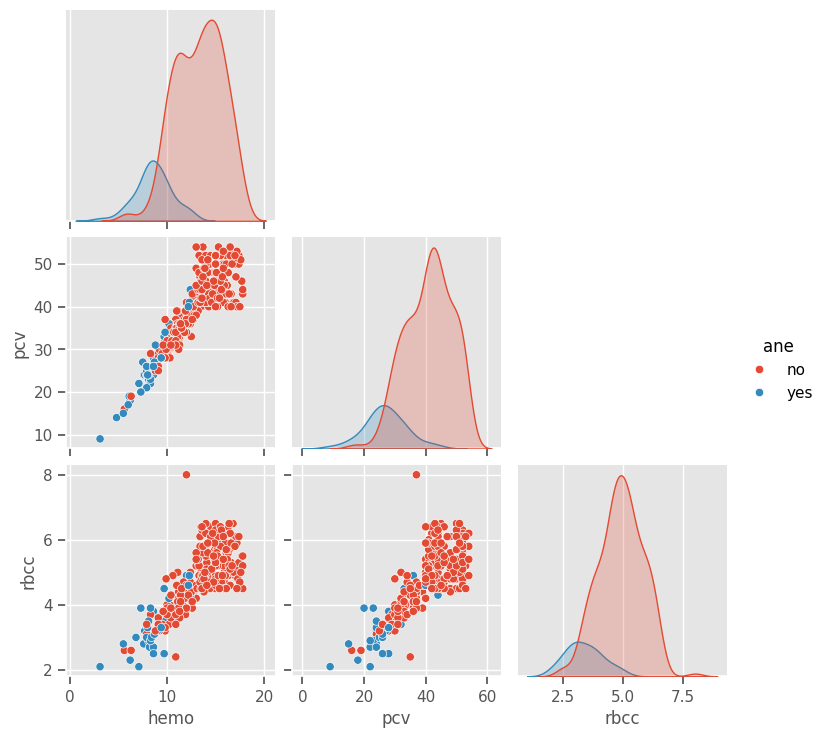

In [18]:
sns.pairplot(
    df,
    vars=["hemo", "pcv", "rbcc"],
    hue="ane",
    corner=True
)

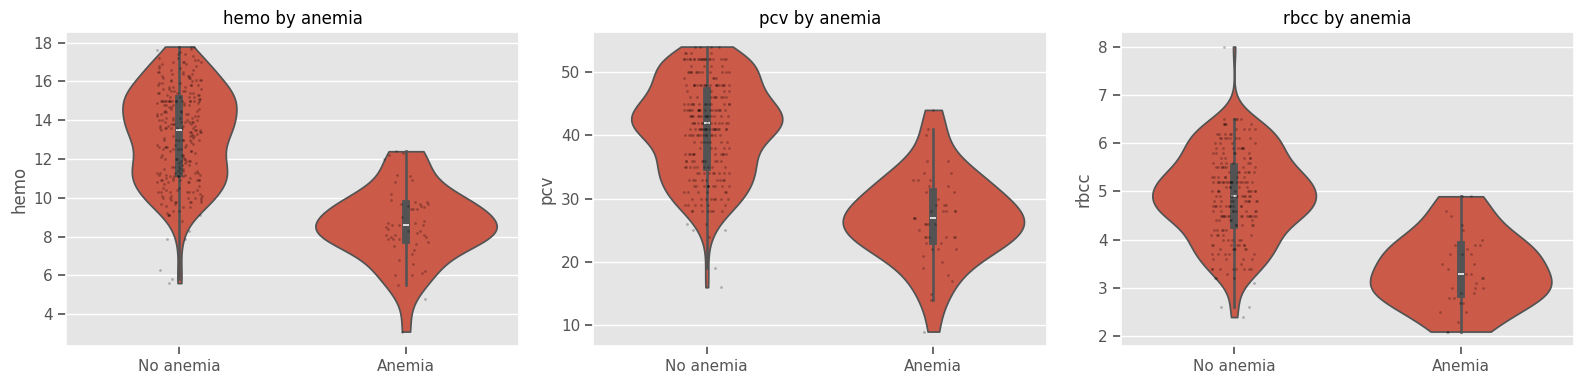

In [19]:
from scipy.stats import spearmanr, pearsonr
#Format p-values for plot text (Spearman/Pearson annotations)
def fmt_p(p): 
    return "< 0.001" if p < 1e-3 else f"= {p:.3f}"

#Clean anemia label + numeric lab values in one expression
ane = (
    df.assign(
        ane=df["ane"].astype("string").str.strip().str.lower(),
        ane_lbl=lambda d: d["ane"].replace({"yes": "Anemia", "no": "No anemia"})
    )
    .assign(**{c: pd.to_numeric(df[c], errors="coerce") for c in ["hemo","pcv","rbcc"]})
    .loc[lambda d: d["ane_lbl"].isin(["Anemia","No anemia"])]
)

#Do the distributions differ between Anemia vs No anemia?” (numeric vs categorical)
#The violin shaped comes in handy to see the distribution's difference
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, x in zip(axes, ["hemo", "pcv", "rbcc"]):
    sns.violinplot(data=ane, x="ane_lbl", y=x, ax=ax, inner="box", cut=0)
    sns.stripplot(data=ane, x="ane_lbl", y=x, ax=ax, color="black", alpha=0.25, size=2)
    ax.set_title(f"{x} by anemia")
    ax.set_xlabel("")
    ax.set_ylabel(x)

plt.tight_layout()
plt.show()


**Conclusion for Anemia Profile**: 

The anemia profile revealed strong positive associations among hemoglobin, packed cell volume and red blood cell count, consistent with their shared physiological role in erythropoiesis. Pairwise Spearman correlations ranged from **0.76** to **0.87**, indicating high internal coherence within this feature group. 

Additionally, individuals labeled as anemic consistently exhibited lower values across all three markers compared to non-anemic individuals. These findings suggest that the anemia-related variables capture a common underlying biological process and that the clinical anemia label aligns well with quantitative laboratory measurements.

Since these features are tightly linked, they’re good candidates for multivariate imputation (or at least use the others to predict the missing one) rather than mean/median-only imputation.

### 2. The diabetes and glucose profile

Diabetes mellitus is the leading cause of chronic kidney disease worldwide and represents a major risk factor for both the development and progression of renal dysfunction. Chronic hyperglycemia induces structural and functional damage to the renal microvasculature, ultimately leading to diabetic kidney disease.

- `bgr` a quantitative measure reflecting circulating glucose levels at the time of sampling.
- `dm` a binary clinical variable indicating whether a diagnosis of diabetes has been established.
- `su` a semi-quantitative ordinal variable reflecting glucosuria, which may occur when blood glucose exceeds renal reabsorption capacity.

These three variables are clinically linked, bgr measures glucose directly, su reflects glucose spilling into urine, and both are expected to align with dm.


<Axes: xlabel='dm', ylabel='bgr'>

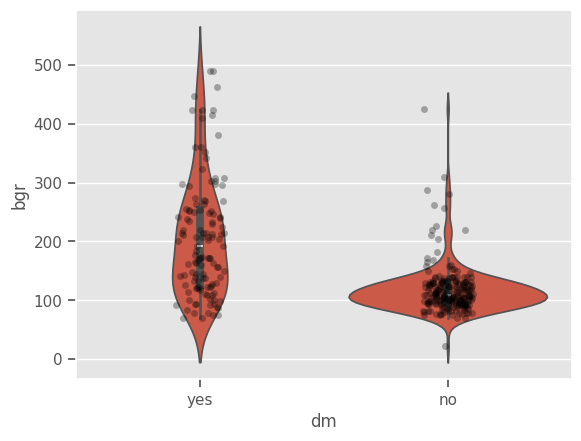

In [20]:
sns.violinplot(data=df, x="dm", y="bgr")
sns.stripplot(data=df, x="dm", y="bgr", color="black", alpha=0.3)


In [21]:
df.groupby("dm")[["bgr"]].describe()


bgr                                                         
     count        mean        std   min    25%    50%    75%    max
dm                                                                 
no   229.0  117.524017  41.416113  22.0   95.0  109.0  129.0  425.0
yes  125.0  204.816000  99.067864  70.0  125.0  192.0  253.0  490.0

In [22]:
pd.crosstab(df["dm"], df["su"], normalize="index")


su,0.0,1.0,2.0,3.0,4.0,5.0
dm,,,,,,
no,0.963265,0.012245,0.012245,0.008163,0.004082,0.000000
yes,0.500000,0.096154,0.144231,0.115385,0.115385,0.028846


The diabetes and glucose profile exhibits a coherent but heterogeneous pattern. Individuals diagnosed with diabetes show higher random blood glucose levels and a markedly higher prevalence of glucosuria. However, substantial overlap between diabetic and non-diabetic groups is observed, particularly for blood glucose measurements, reflecting the use of random (non-fasting) glucose values and inter-individual variability. This heterogeneity highlights the complementary roles of biochemical measurements and clinical diagnosis in characterizing glucose dysregulation.

### 3. The urinalysis profile

Urinalysis plays a central role in the clinical evaluation of chronic kidney disease, as it provides direct evidence of renal damage and alterations in urinary tract physiology. Abnormalities detected in urine may reflect glomerular injury, tubular dysfunction or inflammatory and infectious processes often preceding detectable changes in blood-based markers of renal function.

In the context of CKD, markers such as albuminuria and altered urine concentration capacity are key indicators of kidney damage, while the presence of red blood cells, white blood cells or bacteria may indicate concomitant urinary tract pathology. The urinalysis profile therefore captures both renal-specific and secondary pathological processes relevant to CKD assessment.

The urinalysis profile includes the following variables:
- `sg` an ordinal variable reflecting urine concentration capacity and tubular function.
- `al` a semi-quantitative ordinal measure of albuminuria, which represents a hallmark marker of renal damage.
- `su` an ordinal indicator of glucosuria, reflecting altered renal glucose handling.
- `rbc` indicating hematuria when abnormal.
- `pc`, `pcc`and `ba` which collectively capture inflammatory or infectious processes within the urinary tract.

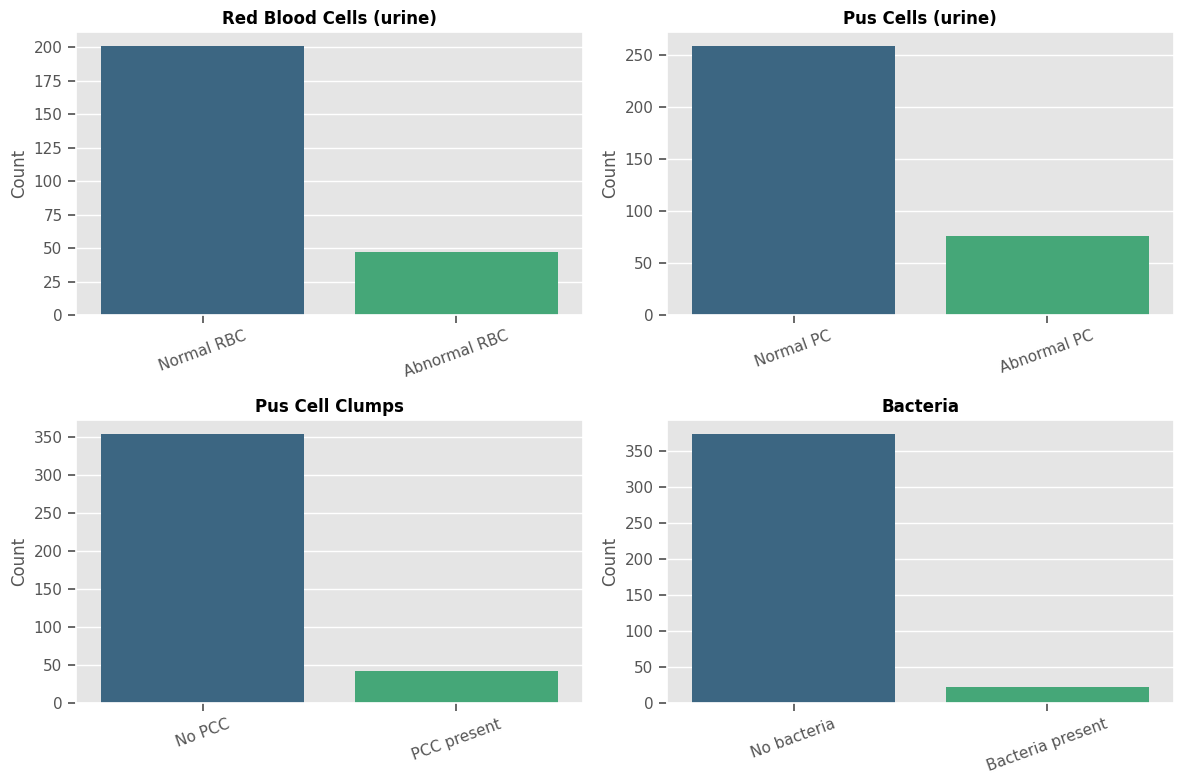

In [23]:
#Let's first define the urinalysis subset
u_cols = ["sg","al","rbc","pc","pcc","ba", "su"]
df_u = df.copy() #a copy of the original dataset

#Labels for plots
df_u["rbc"] = df_u["rbc"].map({"normal":"Normal RBC", "abnormal":"Abnormal RBC"})
df_u["pc"]  = df_u["pc"].map({"normal":"Normal PC", "abnormal":"Abnormal PC"})
df_u["pcc"] = df_u["pcc"].map({"notpresent":"No PCC", "present":"PCC present"})
df_u["ba"]  = df_u["ba"].map({"notpresent":"No bacteria", "present":"Bacteria present"})

#Categorical distributions (rbc, pc, pcc, ba)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col, title in zip(
    axes,
    ["rbc","pc","pcc","ba"],
    ["Red Blood Cells (urine)", "Pus Cells (urine)", "Pus Cell Clumps", "Bacteria"]
):
    sns.countplot(data=df_u, x=col, hue=col, ax=ax, palette="viridis", dodge=False, legend=False)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

Most patients have normal `rbc`, `pc`, `no pcc` and `no ba` while a small group of people show abnormal `rbc` and `pc` and the presence of `pcc` and `ba`.

In [24]:
df[clinical_profiles["urinalysis"]].isna().mean().sort_values(ascending=False)


rbc    0.3800
pc     0.1625
su     0.1225
sg     0.1175
al     0.1150
pcc    0.0100
ba     0.0100
dtype: float64

Missingness in urinalysis variables is uneven and likely clinically driven rather than random.

In [25]:
df["al"].value_counts(dropna=False).sort_index()
df["sg"].value_counts(dropna=False).sort_index()


sg
1.005      7
1.010     84
1.015     75
1.020    106
1.025     81
NaN       47
Name: count, dtype: int64

Specific gravity behaves as an ordered categorical variable with clinically meaningful discrete levels.

In [26]:
pd.crosstab(df["status"], df["al"], normalize="index")


al,0.0,1.0,2.0,3.0,4.0,5.0
status,,,,,,
ckd,0.258373,0.210526,0.205742,0.205742,0.114833,0.004785
notckd,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Albuminuria was exclusively observed among individuals classified as having CKD, indicating a strong association between albumin levels and disease status.

In [27]:
pd.crosstab(df["status"], df["rbc"], normalize="index")


rbc,abnormal,normal
status,,
ckd,0.439252,0.560748
notckd,0.000000,1.000000


Ordinal by status

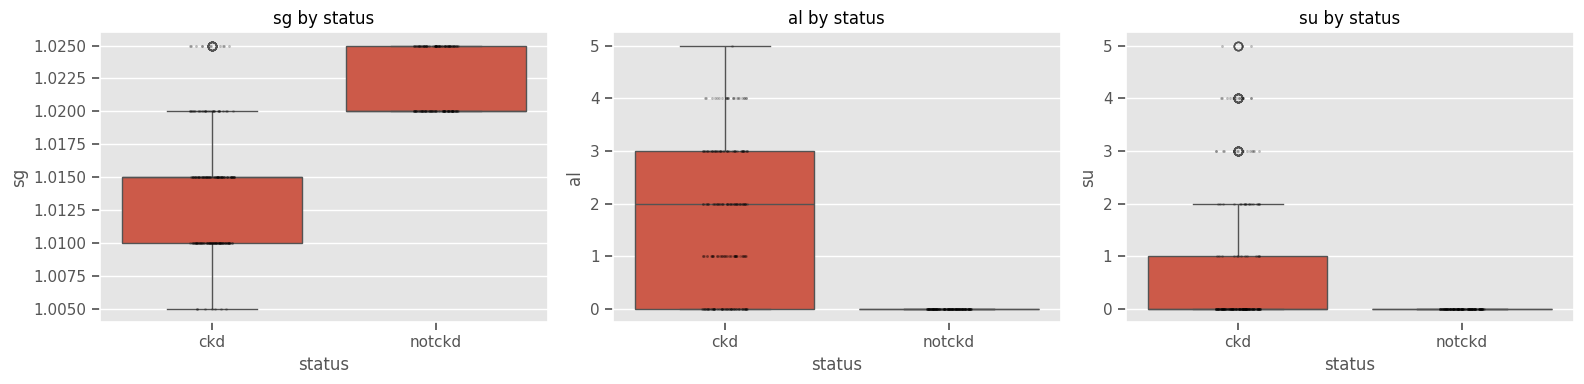

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, x in zip(axes, ["sg","al","su"]):
    sns.boxplot(data=df_u, x="status", y=x, ax=ax)
    sns.stripplot(data=df_u, x="status", y=x, ax=ax, color="black", alpha=0.25, size=2)
    ax.set_title(f"{x} by status")
plt.tight_layout()
plt.show()


Plot sg vs al

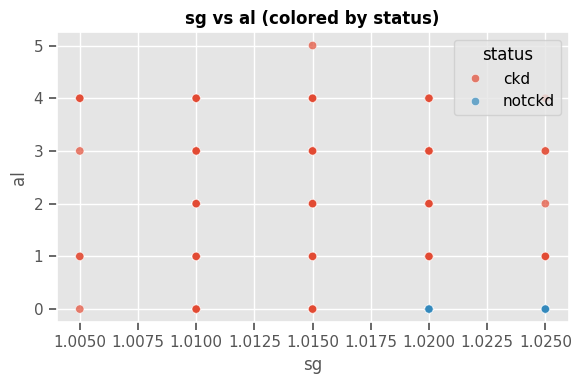

In [29]:
tmp = df_u[["sg","al","status"]].dropna()
plt.figure(figsize=(6,4))
sns.scatterplot(data=tmp, x="sg", y="al", hue="status", alpha=0.7)
plt.title("sg vs al (colored by status)", fontweight="bold")
plt.tight_layout()
plt.show()


CKD shifts toward higher al, more su, and lower sg. 

**Conclusions for Urinalysis Profile**

Abnormal urinary red blood cells were present in a substantial subset of CKD patients but were absent among non-CKD individuals.

Exploratory analysis of the urinalysis profile revealed heterogeneous patterns across variables. Missing values were unevenly distributed, with microscopic urine parameters such as red blood cells showing a notably higher proportion of missingness, suggesting clinically driven measurement practices rather than random absence of data.

Ordinal markers such as specific gravity displayed clinically plausible discrete distributions, reflecting variability in urine concentration capacity. Albuminuria showed a strong association with CKD status, as all non-CKD individuals exhibited normal albumin levels, whereas varying degrees of albuminuria were observed exclusively among CKD cases.

Similarly, abnormal urinary red blood cells were present in a substantial subset of individuals with CKD but were absent in the non-CKD group, indicating that hematuria represents a frequent but not universal manifestation of renal pathology.

### 4. The renal function profile

Assessment of renal function is central to the diagnosis and staging of chronic kidney disease. Reduced glomerular filtration leads to the accumulation of nitrogenous waste products in blood, most notably creatinine and urea. These biomarkers are routinely used in clinical practice to evaluate kidney function and constitute the basis for estimating glomerular filtration rate.

In this dataset, renal function is primarily characterized using serum creatinine and blood urea levels. These variables provide a functional assessment of kidney clearance capacity and are expected to be strongly associated with CKD status.

The renal function profile includes the following variables:
- `sc` a blood biomarker reflecting the accumulation of creatinine due to reduced renal clearance.
- `bu` a nitrogenous waste product whose concentration increases with impaired kidney function and altered protein metabolism.

<Axes: xlabel='sc', ylabel='Count'>

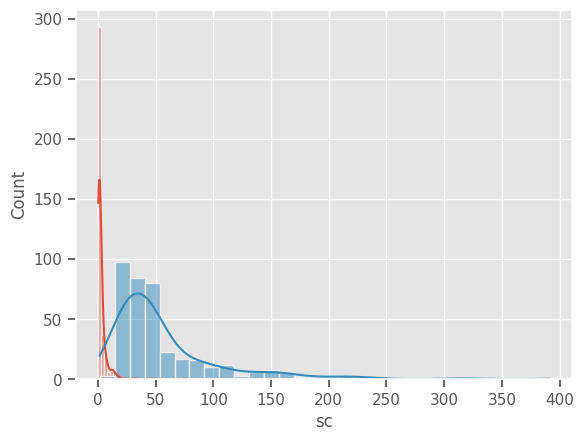

In [30]:
sns.histplot(df["sc"], bins=30, kde=True)
sns.histplot(df["bu"], bins=30, kde=True)


Serum creatinine displays a strongly right-skewed distribution, reflecting the accumulation of extreme values in individuals with advanced renal impairment.

The right tail of the creatinine distribution is driven almost exclusively by CKD cases. There is minimal overlap between CKD and non-CKD groups in terms of serum creatinine.

<Axes: xlabel='status', ylabel='sc'>

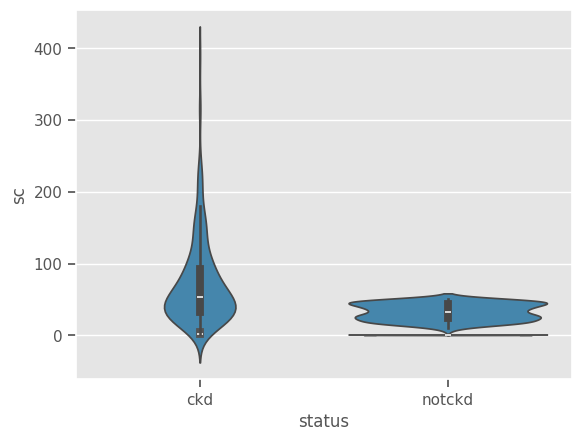

In [31]:
sns.violinplot(data=df, x="status", y="sc")
sns.violinplot(data=df, x="status", y="bu")



MWU tests (Not CKD vs CKD) + rank-biserial:
 bu: U=8486.5, p=1.869e-16, rbc=0.503 | median NotCKD=33 vs CKD=53
 sc: U=2668.5, p=6.578e-44, rbc=0.845 | median NotCKD=0.9 vs CKD=2.25


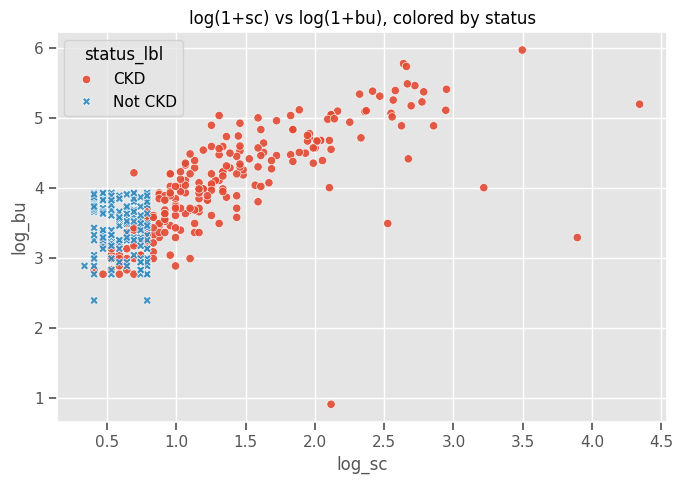

In [32]:
from scipy.stats import mannwhitneyu, chi2_contingency

d = df.copy() #working with the copy of the original dataset 

#Standardize labels
d["status_lbl"] = d["status"].astype(str).str.strip().str.lower().map({
    "ckd": "CKD",
    "notckd": "Not CKD",
    "not ckd": "Not CKD"
})

#Numeric columns for this profile
kidney_cols = ["bu", "sc"]
for c in kidney_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")

#Keep rows that have status + at least one marker
dk = d.dropna(subset=["status_lbl"])
#keep only CKD/Not CKD
dk = dk[dk["status_lbl"].isin(["CKD", "Not CKD"])]

# MWU tests + rank-biserial effect size
def rank_biserial_from_u(U, n1, n2):
    # RBC = 1 - 2U/(n1*n2) when U is for group1 vs group2
    return 1 - (2 * U) / (n1 * n2)

print("\nMWU tests (Not CKD vs CKD) + rank-biserial:")
for c in kidney_cols:
    a = dk.loc[dk["status_lbl"]=="Not CKD", c].dropna()
    b = dk.loc[dk["status_lbl"]=="CKD", c].dropna()
    if len(a) < 5 or len(b) < 5:
        print(f" {c}: not enough data")
        continue

    U, p = mannwhitneyu(a, b, alternative="two-sided")
    rbc = rank_biserial_from_u(U, len(a), len(b))
    print(f" {c}: U={U:.1f}, p={p:.3e}, rbc={rbc:.3f} | median NotCKD={np.median(a):g} vs CKD={np.median(b):g}")

#Scatter proof: log(1+sc) vs log(1+bu)
tmp = dk.dropna(subset=["sc","bu"]).copy()
tmp["log_sc"] = np.log1p(tmp["sc"])
tmp["log_bu"] = np.log1p(tmp["bu"])

plt.figure(figsize=(7,5))
sns.scatterplot(data=tmp, x="log_sc", y="log_bu", hue="status_lbl", style="status_lbl", alpha=0.9)
plt.title("log(1+sc) vs log(1+bu), colored by status")
plt.tight_layout()
plt.show()

In our data, serum creatinine (`sc`) is the significant kidney marker because it is much higher in CKD than non-CKD (median 2.25 vs 0.9, MWU p ≈ 2e−46). Blood urea (`bu`) also separates the groups well (median 53 vs 33, p ≈ 1e−18). Since our data it was strongly right-skewed logs are used to respond to skewness towards large values; e.g., cases in which one or a few points are much larger than the bulk of the data.

In [33]:
df.groupby("status")[["sc", "bu"]].describe()


sc                                                       bu  \
        count      mean       std  min    25%   50%   75%   max  count   
status                                                                   
ckd     238.0  4.414916  6.950275  0.5  1.425  2.25  4.55  76.0  237.0   
notckd  145.0  0.868966  0.255092  0.4  0.600  0.90  1.10   1.2  144.0   

                                                              
             mean        std   min    25%   50%   75%    max  
status                                                        
ckd     72.389030  58.587236   1.5  32.00  53.0  93.0  391.0  
notckd  32.798611  11.450459  10.0  23.75  33.0  44.0   50.0

CKD is associated with both elevated and highly variable creatinine levels, whereas non-CKD individuals show stable and physiologically constrained values. Serum creatinine appears more discriminative of CKD status than blood urea, consistent with its central role in renal function assessment.

### 5. The cardiovascular profile

Cardiovascular disease and altered fluid homeostasis are closely linked to chronic kidney disease. Hypertension represents both a major risk factor for CKD development and a frequent consequence of impaired renal function, while cardiovascular comorbidities often coexist due to shared risk factors and systemic vascular damage. Additionally, reduced renal excretory capacity may lead to fluid retention, clinically manifested as peripheral edema.

This profile captures key cardiovascular conditions and clinical signs related to circulatory and volume regulation, providing contextual information on disease burden and systemic involvement.

The cardiovascular and fluid balance profile includes the following variables:
- `htn` a binary clinical diagnosis indicating the presence of elevated blood pressure.
- `cad` eflecting established cardiovascular pathology.
- `pe` a clinical sign of fluid retention commonly associated with impaired renal and cardiac function.
- `bp` is a key numeric marker that aligns with cardiovascular comorbidities.

These variables represent clinically interpreted conditions rather than direct laboratory measurements and are expected to be more heterogeneous and less tightly correlated than biochemical markers.

In [34]:
pd.crosstab(df["status"], df["htn"], normalize="index")
pd.crosstab(df["status"], df["cad"], normalize="index")
pd.crosstab(df["status"], df["pe"], normalize="index")


pe,no,yes
status,,
ckd,0.696,0.304
notckd,1.000,0.000


In [35]:
pd.crosstab(df["htn"], df["pe"], normalize="index")


pe,no,yes
htn,,
no,0.920000,0.080000
yes,0.619048,0.380952


Pedal edema was observed exclusively among CKD patients, affecting approximately one third of cases, consistent with its role as a clinical manifestation of fluid retention rather than a defining feature of CKD.

Pedal edema was substantially more prevalent among hypertensive individuals, supporting the link between blood pressure dysregulation and fluid retention.

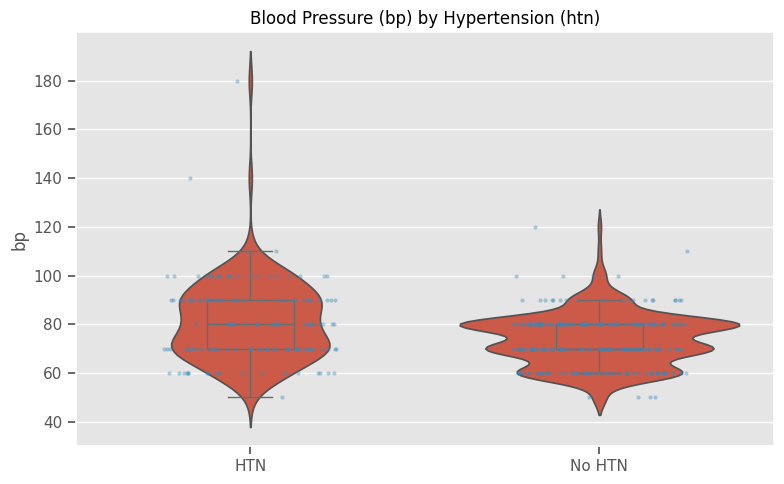

In [36]:
# Hypertension + Cardiovascular profile (bp <-> htn <-> cad) 

#We will work with a copy of the original dataset 
df_h = df.copy(deep=True)

#Ensure bp numeric
df_h["bp"] = pd.to_numeric(df_h["bp"], errors="coerce")

#Clean categorical strings
for c in ["htn", "cad", "status"]:
    if c in df_h.columns:
        df_h[c] = df_h[c].astype("string").str.strip().str.lower()

#Create nice labels
df_h["htn_lbl"] = df_h["htn"].map({"yes": "HTN", "no": "No HTN"})
df_h["cad_lbl"] = df_h["cad"].map({"yes": "CAD", "no": "No CAD"})

#Drop rows where we cannot evaluate (bp or htn missing)
df_bp_htn = df_h.dropna(subset=["bp", "htn_lbl"]).copy()

#BP distribution by HTN (violin/box)
plt.figure(figsize=(8,5))
sns.violinplot(data=df_bp_htn, x="htn_lbl", y="bp", inner=None)
sns.stripplot(data=df_bp_htn, x="htn_lbl", y="bp", alpha=0.4, jitter=0.25, size=3)
sns.boxplot(data=df_bp_htn, x="htn_lbl", y="bp", width=0.25, showcaps=True,
            boxprops={'facecolor':'none'}, showfliers=False)
plt.title("Blood Pressure (bp) by Hypertension (htn)")
plt.xlabel("")
plt.ylabel("bp")
plt.tight_layout()
plt.show()

In [37]:
#STAT TEST: BP differs by HTN? (Mann–Whitney U)
bp_no = df_bp_htn.loc[df_bp_htn["htn_lbl"]=="No HTN", "bp"].dropna()
bp_yes = df_bp_htn.loc[df_bp_htn["htn_lbl"]=="HTN", "bp"].dropna()
U, p = mannwhitneyu(bp_no, bp_yes, alternative="two-sided")
#Rank-biserial (direction depends on ordering)
n1, n2 = len(bp_no), len(bp_yes)
rbc = 1 - (2*U)/(n1*n2)
print(f"MWU bp by htn (No HTN vs HTN): U={U:.1f}, p={p:.3e}, rank-biserial={rbc:.3f} | n(no)={n1}, n(yes)={n2}")
print(f"median bp No HTN: {np.median(bp_no):.1f} | HTN: {np.median(bp_yes):.1f}")


MWU bp by htn (No HTN vs HTN): U=12507.5, p=1.416e-06, rank-biserial=0.284 | n(no)=241, n(yes)=145
median bp No HTN: 70.0 | HTN: 80.0


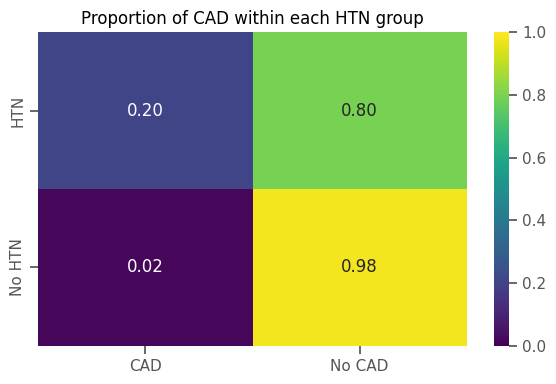


Counts CAD vs HTN:
cad_lbl  CAD  No CAD
htn_lbl             
HTN       30     117
No HTN     4     247

Chi-square test (htn vs cad): chi2=39.629, dof=1, p=3.070e-10, Cramer's V=0.325


In [38]:
#CAD prevalence within HTN groups (proportions heatmap)
df_htn_cad = df_h.dropna(subset=["htn_lbl", "cad_lbl"]).copy()
ct = pd.crosstab(df_htn_cad["htn_lbl"], df_htn_cad["cad_lbl"])
prop = ct.div(ct.sum(axis=1), axis=0)
#plot
plt.figure(figsize=(6,4))
sns.heatmap(prop, annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1)
plt.title("Proportion of CAD within each HTN group")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()
print("\nCounts CAD vs HTN:")
print(ct)

#STAT TEST: CAD associated with HTN? (Chi-square + Cramer's V)
chi2, p_chi, dof, exp = chi2_contingency(ct)
cramers_v = association(ct, method="cramer")
print(f"\nChi-square test (htn vs cad): chi2={chi2:.3f}, dof={dof}, p={p_chi:.3e}, Cramer's V={cramers_v:.3f}")



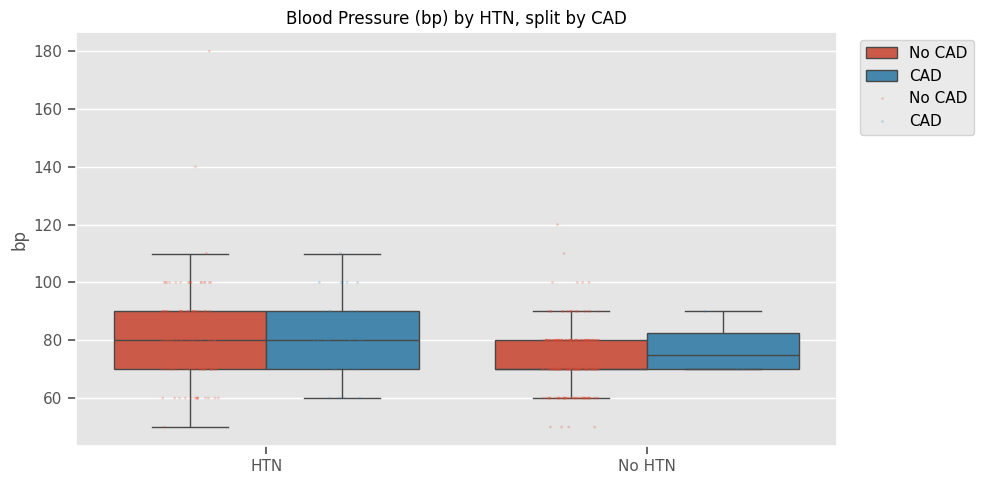

In [39]:
#BP distribution split by BOTH HTN and CAD
# This visualization will help show whether higher bp often coincides with yes htn and yes cad')
df_bp_two = df_h.dropna(subset=["bp","htn_lbl","cad_lbl"]).copy()
plt.figure(figsize=(10,5))
sns.boxplot(data=df_bp_two, x="htn_lbl", y="bp", hue="cad_lbl", showfliers=False)
sns.stripplot(data=df_bp_two, x="htn_lbl", y="bp", hue="cad_lbl",
              dodge=True, alpha=0.25, size=2, jitter=0.15)
plt.title("Blood Pressure (bp) by HTN, split by CAD")
plt.xlabel("")
plt.ylabel("bp")
plt.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

People labeled HTN have higher blood pressure than those labeled No HTN based on the **“bp by htn” violin/strip plot**, where the HTN group is shifted upward(median 80 vs 70; p = 1.416e-06). The plot of bp by HTN split by CAD (hue) supports the interpretation that BP differences mainly track HTN, while CAD is mostly concentrated within the HTN group. 


### 6. The electrolyte profile

Electrolyte balance is tightly regulated by the kidneys and may become altered in chronic kidney disease as renal excretory and regulatory capacity declines. Disturbances in serum sodium and potassium concentrations can reflect impaired tubular handling, altered water balance, and reduced potassium excretion. However, these abnormalities are often intermittent and influenced by multiple systemic factors, including diet, hydration status, and medication use.

As a result, electrolyte levels are expected to show greater variability and lower specificity for CKD compared to direct markers of renal function.

The electrolyte profile includes the following variables:
- `sod` reflecting systemic water and sodium balance.
- `pot` a key electrolyte whose renal excretion is frequently impaired in advanced kidney disease.

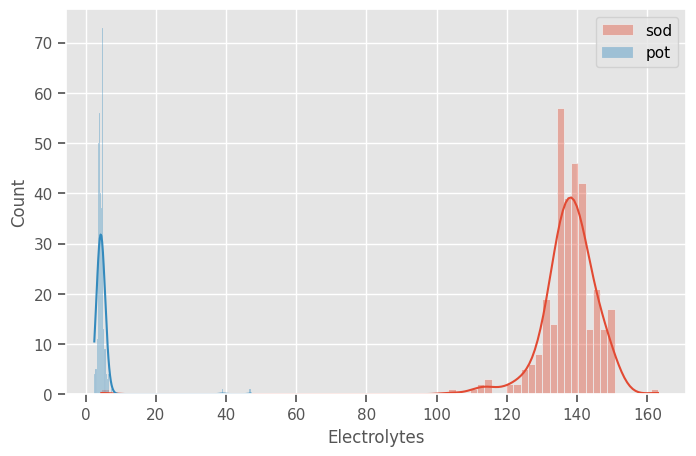

In [40]:
plt.figure(figsize=(8,5))
sns.histplot(df["sod"], kde=True, label="sod", alpha=0.4)
sns.histplot(df["pot"], kde=True, label="pot", alpha=0.4)

plt.xlabel("Electrolytes")   
plt.ylabel("Count")
plt.legend()
plt.show()

 

<Axes: xlabel='status', ylabel='sod'>

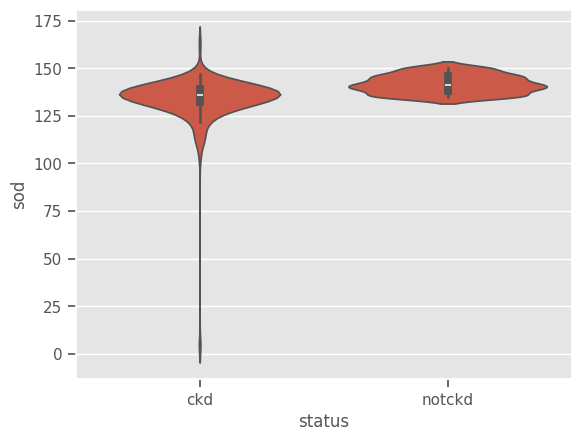

In [41]:
sns.violinplot(data=df, x="status", y="sod")


<Axes: xlabel='status', ylabel='pot'>

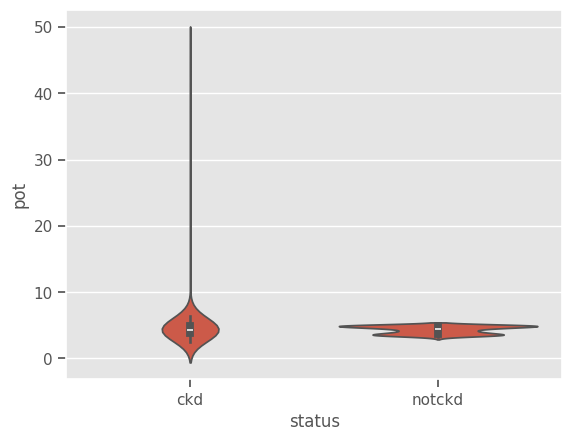

In [42]:
sns.violinplot(data=df, x="status", y="pot")

In [43]:
df.groupby("status")["pot"].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
ckd,167.0,4.878443,4.321550,2.5,3.85,4.3,4.9,47.0
notckd,145.0,4.337931,0.587257,3.3,3.70,4.5,4.9,5.0


In [44]:
df.groupby("status")["sod"].describe()


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
ckd,168.0,133.901786,12.402827,4.5,132.0,136.0,139.0,163.0
notckd,145.0,141.731034,4.817871,135.0,138.0,141.0,146.0,150.0


Statistical Tests

In [45]:
#Numeric columns for this profile
electrolytes_cols = ["sod", "pot"]
for c in electrolytes_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")
    
#MWU tests + rank-biserial effect size
def rank_biserial_from_u(U, n1, n2):
    # RBC = 1 - 2U/(n1*n2) when U is for group1 vs group2
    return 1 - (2 * U) / (n1 * n2)

print("\nMWU tests (Not CKD vs CKD) + rank-biserial:")
for c in electrolytes_cols:
    a = dk.loc[dk["status_lbl"]=="Not CKD", c].dropna()
    b = dk.loc[dk["status_lbl"]=="CKD", c].dropna()
    if len(a) < 5 or len(b) < 5:
        print(f" {c}: not enough data")
        continue

    U, p = mannwhitneyu(a, b, alternative="two-sided")
    rbc = rank_biserial_from_u(U, len(a), len(b))
    print(f" {c}: U={U:.1f}, p={p:.3e}, rank-biserial={rbc:.3f} | median NotCKD={np.median(a):g} vs CKD={np.median(b):g}")



MWU tests (Not CKD vs CKD) + rank-biserial:
 sod: U=19583.0, p=1.499e-20, rank-biserial=-0.608 | median NotCKD=141 vs CKD=136
 pot: U=11893.5, p=7.878e-01, rank-biserial=0.018 | median NotCKD=4.5 vs CKD=4.3


Sodium (`sod`) is lower in CKD (median 136 vs 141, p ≈ 2.5e−26). Potassium (`pot`) does not separate CKD from non-CKD here (p = 0.415) and has an extreme outlier, so it’s not a reliable marker in this dataset as-is.


Potassium levels exhibited greater variability in CKD patients, with occasional elevated values consistent with reduced renal potassium excretion. Nevertheless, the presence of extreme values far outside physiological ranges for both sodium and potassium suggests data quality issues, such as entry or unit inconsistencies, rather than true clinical observations. 

**!!!!!  recall the outliers**

### Overall EDA conclusions

The **anemia profile** showed strong internal coherence between `hem`, `pcv` and `rbcc`, with good alignment between quantitative markers and the clinical anemia label. These findings support treating anemia related variables as a unified clinical block during data preparation.

The **diabetes and glucose profile** exhibited heterogeneous patterns. Although `bgr` and `gc` were more frequent among individuals with diabetes, substantial overlap between groups was observed, reflecting random  measurements and treatment effects. This heterogeneity suggests that glucose-related variables provide complementary but non-deterministic information.

The **urinalysis profile** revealed clinically driven missingness and heterogeneous co-occurrence of abnormalities. `al` and `rbc` were strongly associated with CKD status, while other urine findings appeared in subsets of patients, highlighting the multifactorial nature of renal pathology and the need for cautious handling of missing values. It also reveals tightly coupled urine findings (`rbc`, `pc`, `pcc`, `ba`) and their association with higher `al` and lower `sg`, enabling joint imputation within this block. 

The **renal function profile** demonstrated marked separation between CKD and non-CKD individuals, particularly for `sc` and `bu`. Given their central role in the clinical definition of CKD, these variables were identified as high-risk sources of data leakage and require special consideration in both imputation and modeling.

The **electrolyte profile** indicated that `pot` levels exhibited greater variability in CKD patients, with occasional elevated values consistent with reduced renal potassium excretion. Similarly, with `sod` we observe that it is lower in CKD so it shows a negative association. 



We will impute by profile using multivariate methods (KNN/Iterative) wherever the relationships are strong.

## Fill Missing Values

Based on the exploratory analysis, missing values were handled using clinically informed, profile-based strategies rather than a global imputation approach. Encoding and imputation decisions were guided by the physiological relationships observed within each clinical profile, with particular care taken to preserve biologically plausible value combinations and to avoid information leakage.


### Encoding

Categorical variables were encoded prior to normalization using encoding strategies aligned with their clinical interpretation. Binary encoding was applied to variables representing two clinically distinct states (e.g., yes/no, normal/abnormal, present/not present), mapping the normal or baseline state to 0 and the abnormal or pathological state to 1. Ordinal encoding was applied to variables representing ordered clinical scales, preserving the intrinsic ordering of severity. Specifically, urine specific gravity (sg) and semi-quantitative measures of albuminuria (al) and glucosuria (su) were encoded according to their established clinical levels.

In particular:
- `sg`: 1.005 < 1.010 < 1.015 < 1.020 < 1.025
- `al`: 0 < 1 < 2 < 3 < 4 < 5
- `su`: 0 < 1 < 2 < 3 < 4 < 5

Variables with very low proportions of missing values (pcc, ba, htn, dm, cad, appet, pe, ane) were imputed using mode substitution, as missingness in these variables was minimal and unlikely to reflect structured clinical patterns.

For variables with clinically meaningful interdependencies, missing values were imputed using profile-based multivariate imputation. Urinalysis variables (rbc, pc, pcc, ba, al, sg) were imputed jointly using an iterative imputation approach with a random forest estimator, preserving the strong internal coupling observed during exploratory analysis. This strategy allows missing values to be filled in a manner consistent with co-occurring urinary abnormalities and underlying renal pathology.

Similarly, the glucose/diabetes profile was imputed jointly by modeling glucosuria (su) as a function of random blood glucose (bgr) and diabetes status (dm), reflecting their complementary but non-deterministic clinical relationship.

In [46]:
df_enc = df.copy(deep=True)

In [47]:
#Let's define the nominal Columns
binary_cols = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane"]
ordinal_cols = ["sg","al","su"] # since we have levels

#Clean whitespace/casing for string categoricals
for c in binary_cols:
    df[c] = df[c].astype("string").str.strip().str.lower()

#Binary mappings
binary_maps = {
    "rbc": {"normal": 0, "abnormal": 1},
    "pc": {"normal": 0, "abnormal": 1},
    "pcc": {"notpresent": 0, "present": 1},
    "ba": {"notpresent": 0, "present": 1},
    "htn": {"no": 0, "yes": 1},
    "dm": {"no": 0, "yes": 1},
    "cad": {"no": 0, "yes": 1},
    "appet": {"good": 0, "poor": 1},
    "pe": {"no": 0, "yes": 1},
    "ane": {"no": 0, "yes": 1},
}

for c in binary_cols:
    df[c] = df[c].map(binary_maps[c])

#Ordinal encoding for sg, al, su
#Convert to numeric safely (will make invalid strings -> NaN)
df["sg"] = pd.to_numeric(df["sg"], errors="coerce")
df["al"] = pd.to_numeric(df["al"], errors="coerce")
df["su"] = pd.to_numeric(df["su"], errors="coerce")

# Explicit order for sg (5 levels)
sg_order = [1.005, 1.010, 1.015, 1.020, 1.025]
sg_map = {v: i for i, v in enumerate(sg_order)}  # 1.005->0 ... 1.025->4
df["sg"] = df["sg"].map(sg_map)

# al and su are already ordered 0..5
df.loc[~df["al"].between(0, 5), "al"] = np.nan
df.loc[~df["su"].between(0, 5), "su"] = np.nan

Create df_encoded (encoded + low-missing mode fill)

In [48]:
#df_encoded = encoded version of df 
df_encoded = df.copy(deep=True)

# MODE fill for low-missing binary columns
low_missing_cols = ["pcc","ba","htn","dm","cad","appet","pe","ane"]
for c in low_missing_cols:
    mode_val = df_encoded[c].mode(dropna=True).iloc[0]
    df_encoded[c] = df_encoded[c].fillna(mode_val)

print("Missing values in the encoded dataframe: ")
df_encoded.isna().sum()

Missing values in the encoded dataframe: 


age         9
bp         12
sg         47
al         46
su         49
rbc       152
pc         65
pcc         0
ba          0
bgr        44
bu         19
sc         17
sod        87
pot        88
hemo       52
pcv        71
wbcc      106
rbcc      131
htn         0
dm          0
cad         0
appet       0
pe          0
ane         0
status      0
dtype: int64

Now we don't have missing values for columns like "pcc","ba","htn","dm","cad","appet","pe","ane". 

In [49]:
# Build df_imputed and ensure no “shape mismatch” happens
df_imputed = df_encoded.copy(deep=True)

### Imputation based on the anemia Profile

From our EDA, we observed strong `hemo–pcv–rbcc` coupling. The following chunk of code imputes `hemo`, `pcv`, `rbcc` jointly, using the other anemia markers + `ane` as a predictor.

In [50]:
df_imputed = df_encoded.copy(deep=True)
anemia_cols = ["hemo", "pcv", "rbcc"]

#make sure numeric
for c in anemia_cols:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

#include ane as a predictor (already 0/1 and mode-filled)
anemia_block = anemia_cols + ["ane"]

imp_anemia = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ),
    max_iter=20,
    initial_strategy="median",
    random_state=42
)

X_imp = imp_anemia.fit_transform(df_imputed[anemia_block])
df_imputed[anemia_block] = X_imp

#keep ane as clean 0/1 int (IterativeImputer outputs floats)
df_imputed["ane"] = df_imputed["ane"].round().clip(0, 1).astype(int)

#safety clips to avoid nonsense values
df_imputed["hemo"] = df_imputed["hemo"].clip(3, 20)
df_imputed["pcv"]  = df_imputed["pcv"].clip(10, 60)
df_imputed["rbcc"] = df_imputed["rbcc"].clip(1, 8)

print("Missing after anemia imputation:")
print(df_imputed[anemia_cols].isna().sum())


Missing after anemia imputation:
hemo    0
pcv     0
rbcc    0
dtype: int64


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Quick Check

In [51]:
print(df_imputed[["hemo","pcv","rbcc"]].corr(method="spearman"))

#anemia label still separates the markers
print(df_imputed.groupby("ane")[["hemo","pcv","rbcc"]].median())


          hemo       pcv      rbcc
hemo  1.000000  0.907628  0.882583
pcv   0.907628  1.000000  0.884164
rbcc  0.882583  0.884164  1.000000
      hemo        pcv      rbcc
ane                            
0    13.00  40.000000  4.588012
1     8.35  25.815979  3.237638


Correlations remain high, and ane=1 group remains lower on all three (`hemo`,`pcv` and `rbcc`).

### Imputation based on the diabetes/ glucose profile

From EDA we found that bgr, su, and dm are linked but not deterministic, the best imputation is joint / multivariate to preserve realistic combinations (e.g., diabetics can have su=0, non-diabetics can rarely have high bgr, etc.).Also, since missingness depends on dm, we must include dm in the imputation model.

impute bgr + su using dm

In [52]:
df_imputed = df_imputed.copy(deep=True)  # continue from our anemia-imputed df

#Let's ensure it's numeric
df_imputed["bgr"] = pd.to_numeric(df_imputed["bgr"], errors="coerce")
df_imputed["su"]  = pd.to_numeric(df_imputed["su"], errors="coerce")

#dm is already be 0/1 and mode-filled in df_encoded
df_imputed["dm"] = pd.to_numeric(df_imputed["dm"], errors="coerce")

#extra predictors (just in case)
extra_preds = []
for c in ["sc", "bu"]:
    if c in df_imputed.columns:
        df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")
        extra_preds.append(c)

glucose_block = ["bgr", "su", "dm"] + extra_preds

print("Missing before glucose imputation:")
print(df_imputed[["bgr","su","dm"]].isna().sum())

imp_glucose = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ),
    max_iter=20,
    initial_strategy="median",
    random_state=42
)

X = imp_glucose.fit_transform(df_imputed[glucose_block])
df_imputed[glucose_block] = X

#Re-enforce types/constraints
df_imputed["dm"] = df_imputed["dm"].round().clip(0, 1).astype(int)
df_imputed["su"] = df_imputed["su"].round().clip(0, 5).astype(int)

#keep bgr in a reasonable numeric range
df_imputed["bgr"] = df_imputed["bgr"].clip(lower=0)

print("\nMissing after glucose imputation:")
print(df_imputed[["bgr","su","dm"]].isna().sum())


Missing before glucose imputation:
bgr    44
su     49
dm      0
dtype: int64

Missing after glucose imputation:
bgr    0
su     0
dm     0
dtype: int64


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Quick Checks 

In [53]:
#su should still correlate positively with bgr
sub = df_imputed[["su","bgr"]].dropna()
rho, p = spearmanr(sub["su"], sub["bgr"])
print("Spearman(su,bgr) after imputation:", round(rho, 3), "n=", len(sub))




Spearman(su,bgr) after imputation: 0.622 n= 400


`su` still correlate positively with `bgr`. 

### Imputation based on the Urinalysis Profile

From the EDA, we found that missingness differs a lot by status (higher in CKD than in notCKD). So, single-column median/mode imputation is risky as it will break realistic co-occurrence patterns. Since, Urinalysis variables strongly predict each other we will do a  joint imputation. In observed data, al > 0 and abnormal rbc appear only in CKD and co-occur with other abnormalities; sg is ordinal and inversely related to albumin (Spearman = -0.520, n = 351). Strong categorical links (pc–pcc V = 0.504, rbc–pc V = 0.414, pc–ba V = 0.315, pcc–ba V = 0.257) capture patterns like “pc=1 → pcc more likely.

In [54]:
# Work on a copy
df_imputed = df_imputed.copy(deep=True)   # or df_encoded.copy(deep=True)

# Columns to impute jointly
ur_cols = ["rbc", "pc", "sg", "al"]              # core
optional = ["pcc", "ba"]                         # we can include these too
use_optional = True
cols_to_impute = ur_cols + (optional if use_optional else [])

# Make sure everything is numeric
for c in cols_to_impute:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

#su can help (already imputed in glucose step)
#Include it as a predictor if available and numeric
predictors = cols_to_impute.copy()
if "su" in df_imputed.columns:
    df_imputed["su"] = pd.to_numeric(df_imputed["su"], errors="coerce")
    predictors += ["su"]

print("Missing BEFORE urinalysis imputation:")
print(df_imputed[cols_to_impute].isna().sum().sort_values(ascending=False))

imp_ur = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ),
    max_iter=20,
    initial_strategy="most_frequent",  # better for mostly-discrete features
    random_state=42
)

X_imp = imp_ur.fit_transform(df_imputed[predictors])
df_imputed[predictors] = X_imp

#Post-process to restore discrete clinical encoding
#Binary
for c in ["rbc", "pc", "pcc", "ba"]:
    if c in df_imputed.columns:
        df_imputed[c] = df_imputed[c].round().clip(0, 1).astype(int)

#Ordinal
if "sg" in df_imputed.columns:
    df_imputed["sg"] = df_imputed["sg"].round().clip(0, 4).astype(int)

if "al" in df_imputed.columns:
    df_imputed["al"] = df_imputed["al"].round().clip(0, 5).astype(int)

print("\nMissing AFTER urinalysis imputation:")
print(df_imputed[cols_to_impute].isna().sum().sort_values(ascending=False))


Missing BEFORE urinalysis imputation:
rbc    152
pc      65
sg      47
al      46
pcc      0
ba       0
dtype: int64

Missing AFTER urinalysis imputation:
rbc    0
pc     0
sg     0
al     0
pcc    0
ba     0
dtype: int64


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Quick validation

In [55]:
print(df_imputed[["sg","al"]].corr(method="spearman"))


          sg        al
sg  1.000000 -0.538896
al -0.538896  1.000000


We still see a negative Spearman correlation (not necessarily exactly −0.520 like before but still meaningfully < 0).

### Imputation based on the Renal Profile

From the EDA, we found that missingness is relatively low for this profile (e.g., ``sc`` missing 4.25% overall (CKD 4.80%, notCKD 3.33%) and ``bu`` missing 4.75% overall (CKD 5.20%, notCKD 4.00%). There's a strong separation by CKD status based on the statistic tests. But there is Right-skew and extreme values present. These extremes can distort imputation if left untreated.

From the stats, ``sc`` and ``bu`` move together (especially in CKD): Spearman(`sc`, ``bu``) 0.703 overall, within CKD, 0.840 (very strong) and notCKD ~ -0.096 (basically none). So, Iterative (multivariate) imputation of sc and bu together, after outlier handling, ideally on a log scale make sense here.

In [56]:
df_imputed = df_imputed.copy(deep=True)  #working with a copy

#ensure numeric
for c in ["sc","bu"]:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

#handle extreme nonsense (choose thresholds you can justify)
df_imputed.loc[df_imputed["sc"] > 25, "sc"] = np.nan
df_imputed.loc[df_imputed["bu"] > 250, "bu"] = np.nan

#log transform
df_imputed["log_sc"] = np.log1p(df_imputed["sc"])
df_imputed["log_bu"] = np.log1p(df_imputed["bu"])

#joint imputation in log space
imp = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, min_samples_leaf=2),
    max_iter=20,
    initial_strategy="median",
    random_state=42
)
X = imp.fit_transform(df_imputed[["log_sc","log_bu"]])
df_imputed[["log_sc","log_bu"]] = X

#back-transform
df_imputed["sc"] = np.expm1(df_imputed["log_sc"]).clip(lower=0)
df_imputed["bu"] = np.expm1(df_imputed["log_bu"]).clip(lower=0)

#cleanup
df_imputed.drop(columns=["log_sc","log_bu"], inplace=True)

print(df_imputed[["sc","bu"]].isna().sum())


sc    0
bu    0
dtype: int64


### Imputation based on the Electrolytes Profile 

For the electrolytes profile (`sod`, `pot`) we found two key things, missingness is high and not random + strongly status-dependent
and there is presence of extreme outliers. So, for this profile we can do:
- Outlier handling first (convert implausible values to missing)
- Impute with a multivariate method (IterativeImputer + RF), using non-leaky predictors.

In [57]:
df_imputed = df_imputed.copy(deep=True)

#ensure numeric
for c in ["sod", "pot", "sc", "bu", "bp"]:
    if c in df_imputed.columns:
        df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

#Outlier handling -> set implausible values to NaN
# (these thresholds are deliberately conservative to catch obvious errors)
df_imputed.loc[(df_imputed["sod"] < 110) | (df_imputed["sod"] > 170), "sod"] = np.nan
df_imputed.loc[(df_imputed["pot"] < 2.5) | (df_imputed["pot"] > 7.5), "pot"] = np.nan

#Joint imputation block (use available, non-leaky predictors)
preds = ["sod", "pot"]

for c in ["sc", "bu", "bp", "htn", "pe"]:
    if c in df_imputed.columns:
        preds.append(c)

imp_elec = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ),
    max_iter=20,
    initial_strategy="median",
    random_state=42
)

X = imp_elec.fit_transform(df_imputed[preds])
df_imputed[preds] = X

#sanity constraints after imputation
df_imputed["sod"] = df_imputed["sod"].clip(110, 170)
df_imputed["pot"] = df_imputed["pot"].clip(2.5, 7.5)

print(df_imputed[["sod","pot"]].isna().sum())


sod    0
pot    0
dtype: int64


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [58]:
df_imputed.isna().sum()

age         9
bp          0
sg          0
al          0
su          0
rbc         0
pc          0
pcc         0
ba          0
bgr         0
bu          0
sc          0
sod         0
pot         0
hemo        0
pcv         0
wbcc      106
rbcc        0
htn         0
dm          0
cad         0
appet       0
pe          0
ane         0
status      0
dtype: int64

`Wbcc` is generally influenced by infection/inflammation markers (`pc`/`pcc`/`ba`).So we will use a RF-based iterative imputation preserves realistic patterns (higher wbcc more likely when infection markers are positive).

In [59]:
#continue from our current df_imputed
df_imputed = df_imputed.copy(deep=True)

#ensure numeric
df_imputed["wbcc"] = pd.to_numeric(df_imputed["wbcc"], errors="coerce")

#outlier handling (conservative bounds; adjust if you want stricter)
#typical adult WBC ~ 4k–11k; severe infection/leukemia can be higher
df_imputed.loc[(df_imputed["wbcc"] < 2000) | (df_imputed["wbcc"] > 50000), "wbcc"] = np.nan

#predictors
cand_preds = [
    "pc", "pcc", "ba", "rbc",          # urine inflammation/infection
    "age", "bp",                        # general
    "sc", "bu",                         # renal burden
    "sod", "pot",                       # electrolytes
    "hemo", "pcv", "rbcc",              # hematology context
    "pe", "htn", "dm"                   # clinical context (still non-leaky)
]

preds = ["wbcc"] + [c for c in cand_preds if c in df_imputed.columns]

#ensure numeric for predictors
for c in preds:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

print("Missing BEFORE wbcc imputation:", df_imputed["wbcc"].isna().sum())

imp_wbcc = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    ),
    max_iter=20,
    initial_strategy="median",
    random_state=42
)

X = imp_wbcc.fit_transform(df_imputed[preds])
df_imputed[preds] = X

#post constraints
df_imputed["wbcc"] = df_imputed["wbcc"].clip(2000, 50000)

print("Missing AFTER wbcc imputation:", df_imputed["wbcc"].isna().sum())


Missing BEFORE wbcc imputation: 106
Missing AFTER wbcc imputation: 0


In [60]:
df_imputed.head(2)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,status
0,48.0,80.0,3,1,0.0,1.0,0.0,0.0,0.0,121.000000,36.0,1.2,138.756623,4.155910,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0,ckd
1,7.0,50.0,3,4,0.0,0.0,0.0,0.0,0.0,94.708381,18.0,0.8,137.739528,3.972696,11.3,38.0,6000.0,4.277045,0.0,0.0,0.0,0.0,0.0,0,ckd


## NORMALITZATION

The dataset contains multiple true continuous numeric variables, including `age`, blood pressure (`bp`), random blood glucose (`bgr`), blood urea (`bu`), serum creatinine (`sc`), sodium (`sod`), potassium (`pot`), hemoglobin (`hemo`), packed cell volume (`pcv`), white blood cell count (`wbcc`), and red blood cell count (`rbcc`). These variables exhibit heterogeneous distributions and varying degrees of skewness and outliers, as identified during exploratory analysis.

To ensure comparability across features in distance-based unsupervised analyses, a two-step normalization strategy was applied. First, continuous variables were transformed using the **Yeo–Johnson power transformation**, which reduces both right- and left-skewed distributions while supporting zero and negative values. This approach was selected over simple log transforms to provide a unified treatment across all numeric variables.

Since we are going to test KNN, SVM later which are distance-based and gradient/regularization sensitive respectively. It's better to scale the ordinal variables too (not leave them as raw 0-5). But we will keep a copy with the original just in case.

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

#Keep an untouched copy for interpretation
df_org = df_imputed.copy(deep=True)

#Define column groups
cont_cols = ["age","bp","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]
ord_cols  = ["sg","al","su"]
bin_cols  = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane"]

#keep only existing columns
cont_cols = [c for c in cont_cols if c in df_imputed.columns]
ord_cols  = [c for c in ord_cols  if c in df_imputed.columns]
bin_cols  = [c for c in bin_cols  if c in df_imputed.columns]

feature_cols = cont_cols + ord_cols + bin_cols

#Preprocess (scales/transforms)
preprocess = ColumnTransformer(
    transformers=[
        ("cont", PowerTransformer(method="yeo-johnson", standardize=True), cont_cols),
        ("ord",  MinMaxScaler(), ord_cols),
        ("bin",  "passthrough", bin_cols)
    ],
    remainder="drop"
)

#Full pipeline (preprocess happens only inside model)
model = Pipeline([
    ("pre", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=15))
])



Example usage:
X = df_imputed[feature_cols]
y = df_imputed["status"]   # if predicting status
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [62]:
X = df_imputed[feature_cols].copy()
X_scaled_array = preprocess.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled_array, columns=feature_cols, index=df_imputed.index)


Post-normalization distributions were visually inspected as a quality-control step to confirm appropriate centering and scale comparability prior to feature engineering and unsupervised learning.

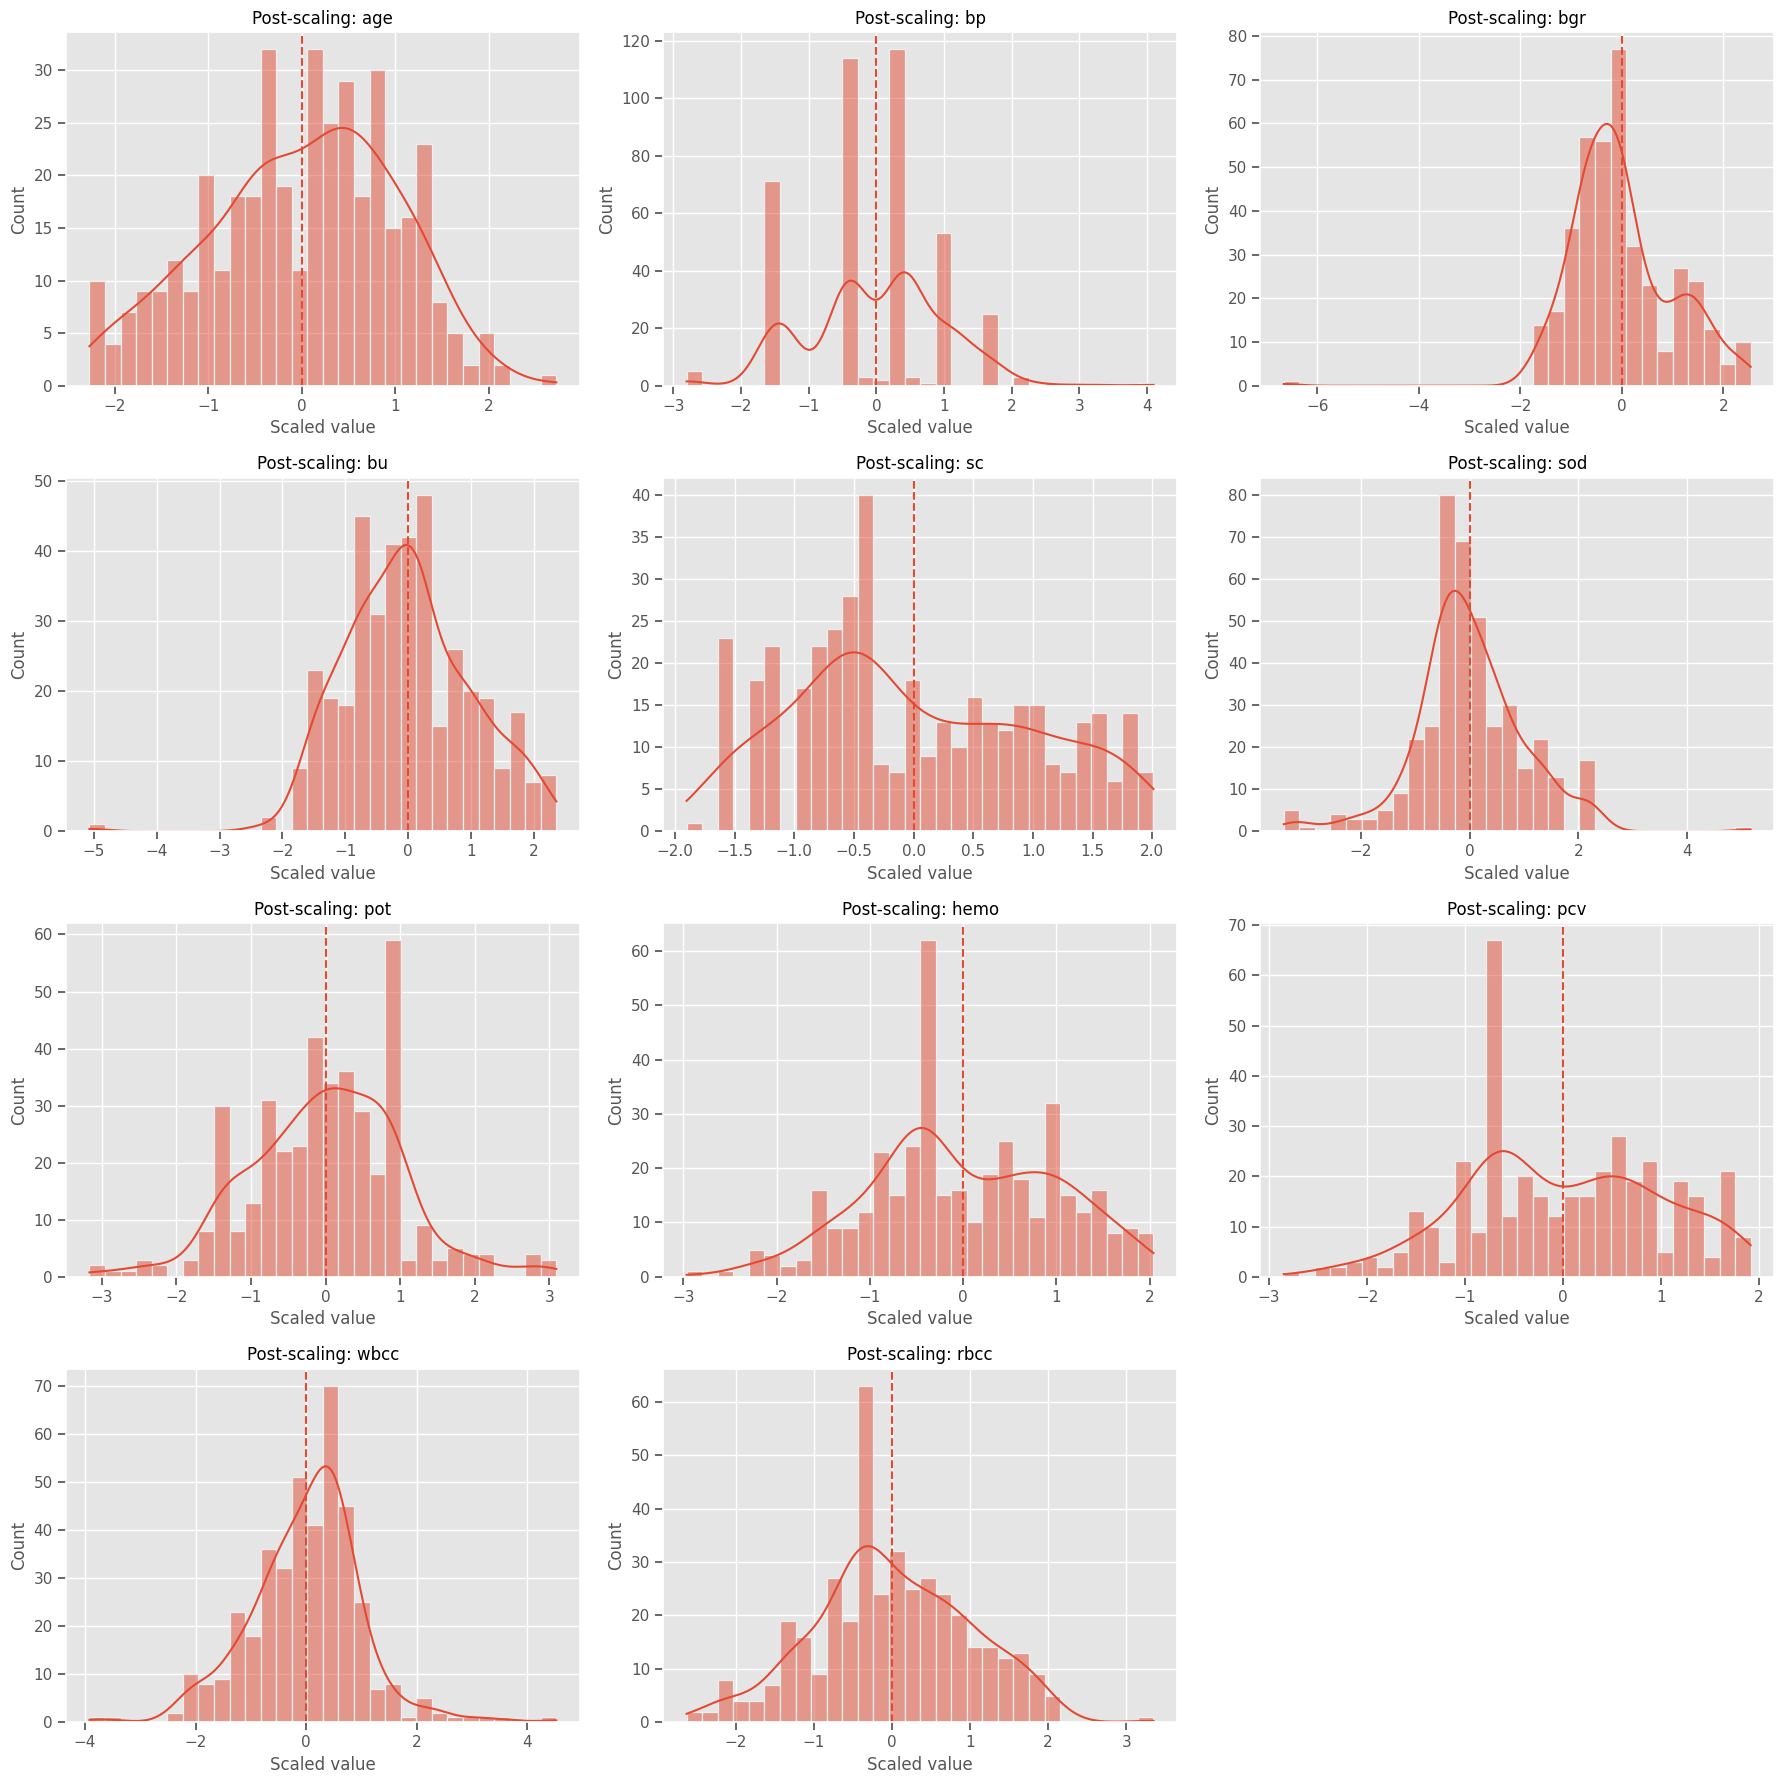

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

#define cont_cols
cont_cols = ["age","bp","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]
cont_cols = [c for c in cont_cols if c in X_scaled_df.columns]

n_cols = 3
n_rows = (len(cont_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4.5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cont_cols):
    x = X_scaled_df[col]
    sns.histplot(x, bins=30, kde=True, ax=axes[i])
    axes[i].axvline(0, linestyle="--")  # reference line
    axes[i].set_title(f"Post-scaling: {col}")
    axes[i].set_xlabel("Scaled value")
    axes[i].set_ylabel("Count")
    

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [64]:
#Start from the fully scaled dataset
df2 = X_scaled_df.copy()
df2["status"] = df_imputed["status"].values
df2.head(5)


,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,sg,al,su,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,status
0,-0.312038,0.407224,-0.149655,-0.293278,-0.369018,0.077122,-0.295741,1.104287,0.718996,-0.192887,0.755196,0.75,0.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,ckd
1,-2.168536,-2.804763,-0.818638,-1.358987,-0.962740,-0.090050,-0.584135,-0.405493,0.026486,-1.052934,-0.179655,0.75,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ckd
2,0.596178,0.407224,2.330530,0.280721,0.200059,-0.177271,0.114895,-0.993463,-0.753787,-0.324635,-0.763301,0.25,0.4,0.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,ckd
3,-0.312038,-0.409254,-0.237228,0.361067,1.060675,-3.412558,-3.164211,-0.440746,-0.644304,-0.697251,-0.576596,0.00,0.8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,ckd
4,-0.127053,0.407224,-0.502083,-0.788340,-0.147267,-0.110303,0.042727,-0.299254,-0.311797,-0.414768,0.153075,0.25,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ckd


### Feature engineering

In [65]:
#Start from the fully scaled dataset
df_norm = df2.copy(deep=True)
#Choose the dataset for clustering
work = df_norm.copy()
#Separate label for visualization only
y_status = work["status"].astype("string").str.strip().str.lower()

#Features only
X = work.drop(columns=["status"]).copy()

#Safety checks
print("Any missing in X?", X.isna().sum().sum())
print("X shape:", X.shape)
print("Status counts:\n", y_status.value_counts(dropna=False))

Any missing in X? 0
X shape: (400, 24)
Status counts:
 status
ckd       250
notckd    150
Name: count, dtype: Int64


# Unsupervised learning Methods: PCA + Kmeans + Hierarchical Clustering

PCA

Explained variance ratio: [0.38974014 0.09505957 0.08653212]
Total explained (PC1+PC2+PC3): 0.5713318236749789


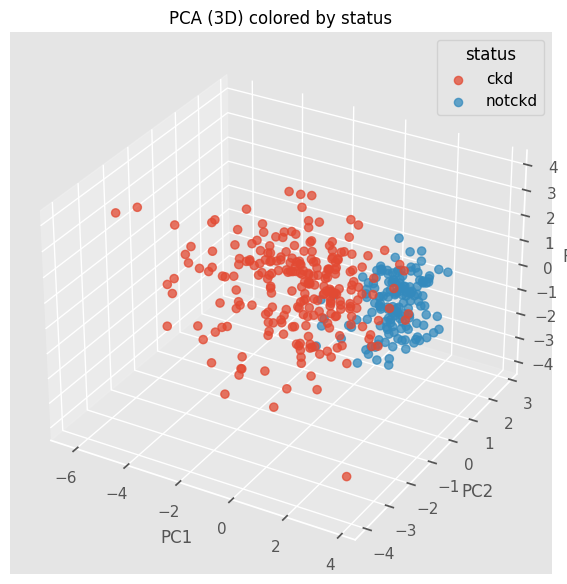

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
 
# PCA to 3D
pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(X)
 
pca_df = pd.DataFrame(Z, columns=["PC1", "PC2", "PC3"])
pca_df["status"] = y_status.values
 
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained (PC1+PC2+PC3):", pca.explained_variance_ratio_.sum())
 
# 3D scatter
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
 
# consistent colors per class
palette = sns.color_palette(n_colors=pca_df["status"].nunique())
color_map = dict(zip(sorted(pca_df["status"].unique()), palette))
 
for label, grp in pca_df.groupby("status"):
    ax.scatter(grp["PC1"], grp["PC2"], grp["PC3"],
               label=label, alpha=0.75, s=35, c=[color_map[label]])
 
ax.set_title("PCA (3D) colored by status")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(title="status")
plt.tight_layout()
plt.show()

What we did basically?
 
We have 24 features. Many of them move together (like urea + creatinine both go up when kidneys are worse). So there’s repeated information. Instead of 24 separate columns, PCA (Principal Component Analysis) create a few new columns that capture the main patterns. PC1,PC2,PC3 are new variables created from our original columns. Each principal component is a weighted combination of all our original numeric features.

The numeric result's interpretation:    
 
- PC1 = 0.38963944 → PC1 alone captures 38.97% of the variance.
- PC2 = 0.09753405 → PC2 captures 9,5% more.
- PC3 = 0.08653212 → PC3 captures 8.65% more.
Together the the first 3 PCs capture about 57.13% of the total variance in X.
 
Graphical Interpretation:
From the graph we can say it's a pretty good separation, mainly because the blue (notckd) points form a tight cluster on one side, while the red (ckd) points sit mostly on a different side with only a few points drifting toward the boundary. In our 3D PCA plot, the two clusters are separated mainly along PC1 (which makes sense because PC1 explains ~36.40% of variance). PC2/PC3 add spread but don’t change the narrative story.

In [67]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(X)

loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=["PC1","PC2","PC3"]
)

print(loadings["PC1"].sort_values(key=lambda s: s.abs(), ascending=False).head(10))


pcv     0.399763
hemo    0.399236
rbcc    0.384279
sc     -0.380304
bu     -0.324418
sod     0.281356
bgr    -0.211192
age    -0.174469
bp     -0.161586
htn    -0.151598
Name: PC1, dtype: float64


K-means

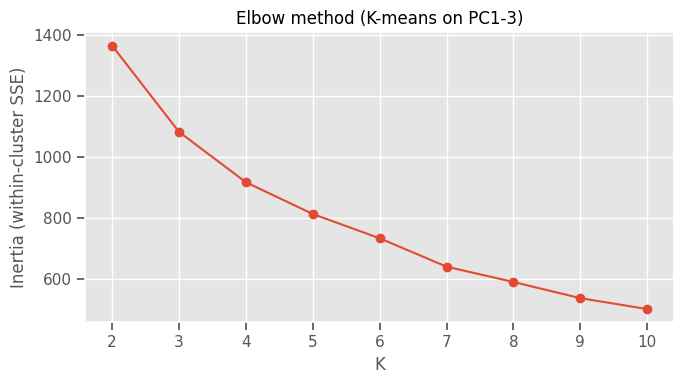

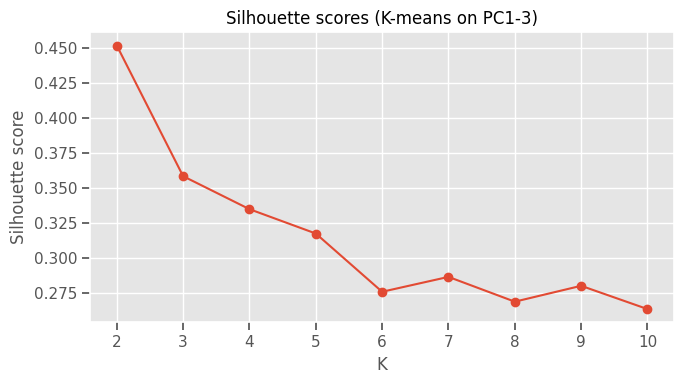

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
 
#PCA to 3 components
pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(X)
 
Ks = range(2, 11)
inertias = []
sil_scores = []
 
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Z)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Z, labels))
 
plt.figure(figsize=(7,4))
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow method (K-means on PC1-3)")
plt.tight_layout()
plt.show()
 
plt.figure(figsize=(7,4))
plt.plot(list(Ks), sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores (K-means on PC1-3)")
plt.tight_layout()
plt.show()
 

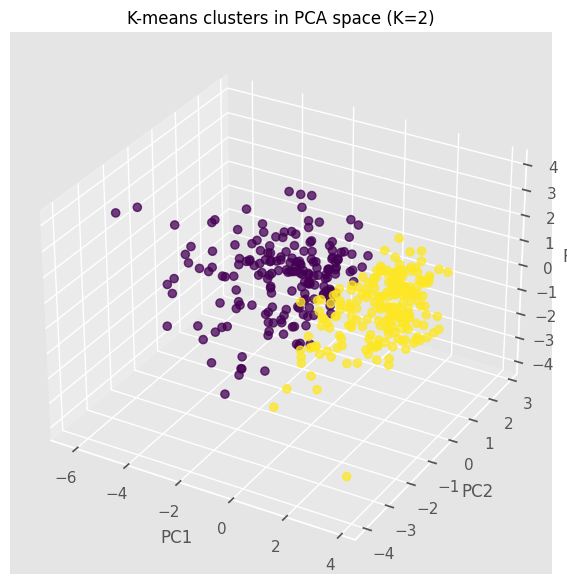

In [69]:
from mpl_toolkits.mplot3d import Axes3D
 
best_k = 2  # change after you inspect elbow/silhouette
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km = km.fit_predict(Z)
 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c=labels_km, alpha=0.75, s=35)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title(f"K-means clusters in PCA space (K={best_k})")
plt.tight_layout()
plt.show()

In [70]:
# cluster labels from KMeans on Z, but labels correspond to rows in X
work = df_norm.copy()
work["cluster"] = labels_km

X_only = work.drop(columns=["status"]).copy()

# difference in cluster means (on scaled data)
diff = (X_only.groupby("cluster").mean().iloc[1] - X_only.groupby("cluster").mean().iloc[0]).abs()
top = diff.sort_values(ascending=False).head(10)
print(top)


sc      1.504968
hemo    1.500838
pcv     1.481227
rbcc    1.398166
bu      1.304759
sod     1.074218
bgr     0.894559
age     0.864643
htn     0.669431
bp      0.600147
dtype: float64


Hierarchical Clustering

In [71]:
X.head(4)

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,sg,al,su,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane
0,-0.312038,0.407224,-0.149655,-0.293278,-0.369018,0.077122,-0.295741,1.104287,0.718996,-0.192887,0.755196,0.75,0.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,-2.168536,-2.804763,-0.818638,-1.358987,-0.962740,-0.090050,-0.584135,-0.405493,0.026486,-1.052934,-0.179655,0.75,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.596178,0.407224,2.330530,0.280721,0.200059,-0.177271,0.114895,-0.993463,-0.753787,-0.324635,-0.763301,0.25,0.4,0.6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-0.312038,-0.409254,-0.237228,0.361067,1.060675,-3.412558,-3.164211,-0.440746,-0.644304,-0.697251,-0.576596,0.00,0.8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


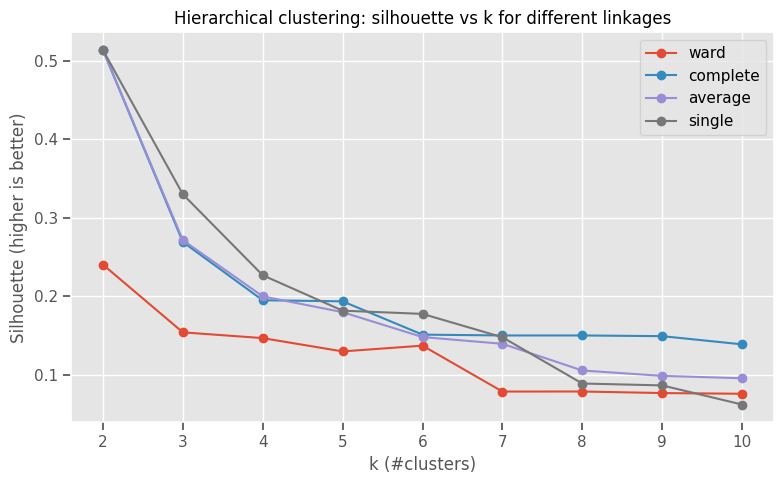

     linkage  k  silhouette
18   average  2    0.513311
27    single  2    0.513311
9   complete  2    0.513311
28    single  3    0.329895
19   average  3    0.271557
10  complete  3    0.269206
0       ward  2    0.240380
29    single  4    0.226870
20   average  4    0.200050
11  complete  4    0.195077


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

# X: scaled features dataframe (no status)
X_mat = X.values  # numpy

# Precompute Euclidean distances once (consistent across linkages)
D = pdist(X_mat, metric="euclidean")                 # condensed distance vector
D_square = squareform(D)                             # for silhouette_score (needs square)

methods = ["ward", "complete", "average", "single"]
Ks = range(2, 11)

results = []

for m in methods:
    Z_link = linkage(D if m != "ward" else X_mat, method=m)  
    # ward expects raw observations; others can take distances via pdist (safer consistency)
    # (SciPy allows passing observation matrix for all methods too; this just makes it explicit)

    for k in Ks:
        labels = fcluster(Z_link, t=k, criterion="maxclust")
        sil = silhouette_score(D_square, labels, metric="precomputed")
        results.append({"linkage": m, "k": k, "silhouette": sil})

res_df = pd.DataFrame(results)

# Plot silhouette vs k for each linkage
plt.figure(figsize=(8,5))
for m in methods:
    sub = res_df[res_df["linkage"] == m]
    plt.plot(sub["k"], sub["silhouette"], marker="o", label=m)
plt.xlabel("k (#clusters)")
plt.ylabel("Silhouette (higher is better)")
plt.title("Hierarchical clustering: silhouette vs k for different linkages")
plt.legend()
plt.tight_layout()
plt.show()

# Show best (linkage, k)
best = res_df.sort_values("silhouette", ascending=False).head(10)
print(best)


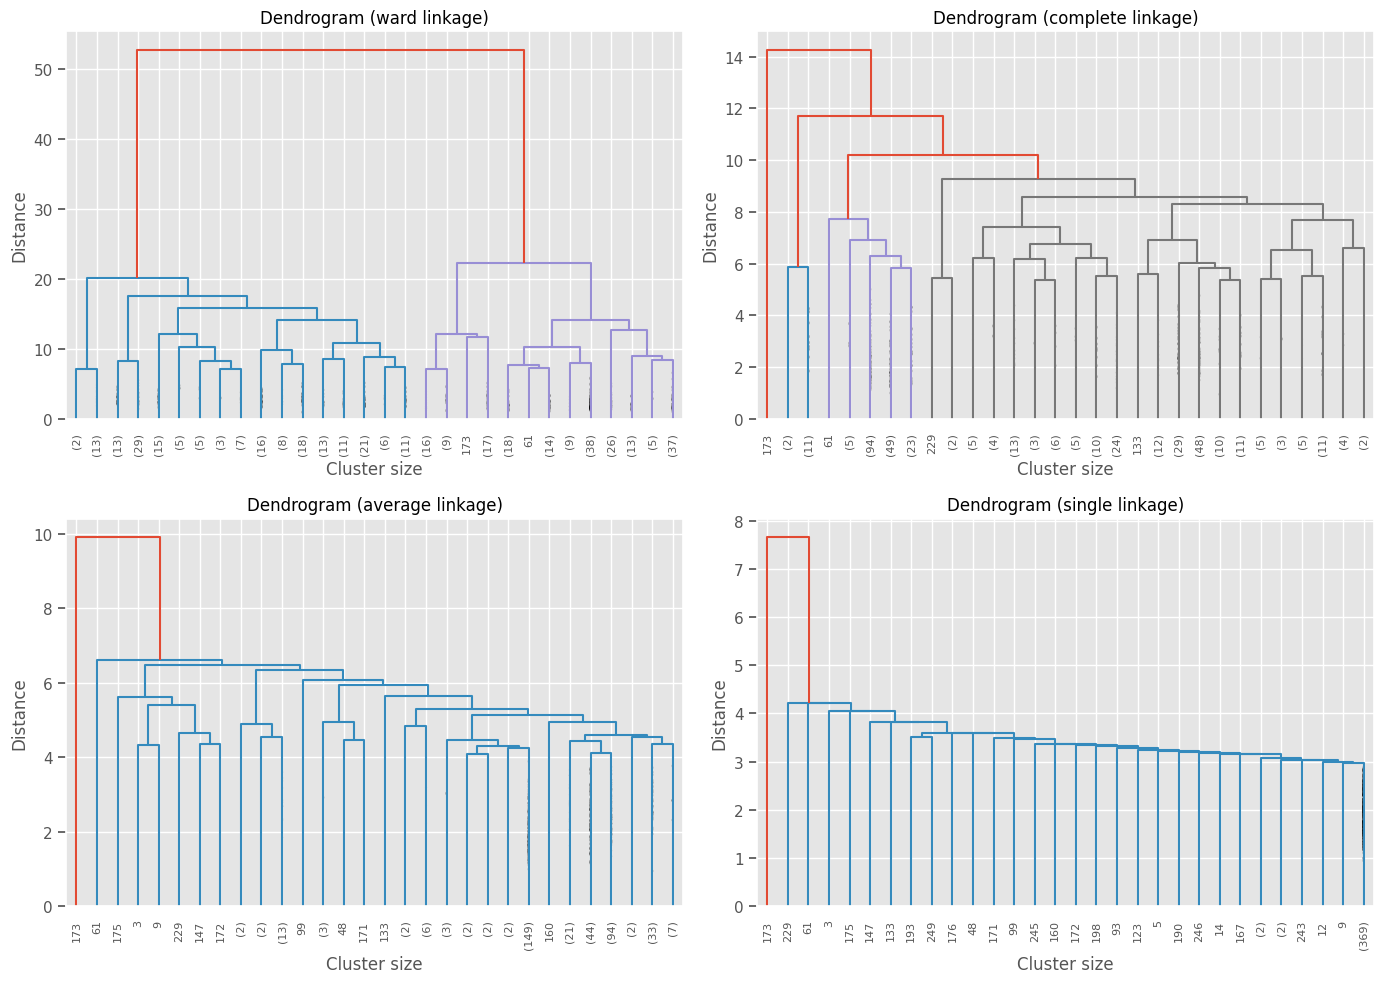

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage

methods = ["ward", "complete", "average", "single"]

plt.figure(figsize=(14, 10))

for i, m in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    Z_link = linkage(X, method=m)  # passing X directly is fine for these methods
    dendrogram(
        Z_link,
        truncate_mode="lastp",
        p=30,
        leaf_rotation=90,
        leaf_font_size=8,
        show_contracted=True
    )
    plt.title(f"Dendrogram ({m} linkage)")
    plt.xlabel("Cluster size")
    plt.ylabel("Distance")

plt.tight_layout()
plt.show()


In [74]:
from scipy.cluster.hierarchy import linkage, fcluster

for method in ["single","average","ward","complete"]:
    Z = linkage(X, method=method)
    labels = fcluster(Z, t=2, criterion="maxclust")
    sizes = pd.Series(labels).value_counts().sort_index()
    print(method, "sizes:", sizes.to_dict())


single sizes: {1: 399, 2: 1}
average sizes: {1: 399, 2: 1}
ward sizes: {1: 196, 2: 204}
complete sizes: {1: 399, 2: 1}


In [75]:
for method in ["single","average","ward","complete"]:
    Z = linkage(X, method=method)
    labels = fcluster(Z, t=2, criterion="maxclust")
    tmp = df2.copy()
    tmp["cluster"] = pd.Series(labels, index=df2.index)

    print("\n", method)
    print(pd.crosstab(tmp["cluster"], tmp["status"]))
    print(pd.crosstab(tmp["cluster"], tmp["status"], normalize="index").round(3))



 single
status   ckd  notckd
cluster             
1        249     150
2          1       0
status     ckd  notckd
cluster               
1        0.624   0.376
2        1.000   0.000

 average
status   ckd  notckd
cluster             
1        249     150
2          1       0
status     ckd  notckd
cluster               
1        0.624   0.376
2        1.000   0.000

 ward
status   ckd  notckd
cluster             
1        192       4
2         58     146
status     ckd  notckd
cluster               
1        0.980   0.020
2        0.284   0.716

 complete
status   ckd  notckd
cluster             
1        249     150
2          1       0
status     ckd  notckd
cluster               
1        0.624   0.376
2        1.000   0.000


In [76]:
# Identify the singleton for single linkage
Z = linkage(X, method="single")
labels = fcluster(Z, t=2, criterion="maxclust")

singleton_idx = pd.Series(labels, index=df2.index).value_counts().idxmin()
outlier_rows = df2[pd.Series(labels, index=df2.index) == singleton_idx]

print("Outlier row index:", outlier_rows.index.tolist())
print(outlier_rows.T.head(30))  # view values
print("Status:", df2.loc[outlier_rows.index, "status"].values)


Outlier row index: [173]
             173
age    -1.856382
bp     -0.409254
bgr    -6.657098
bu     -5.070315
sc      1.561232
sod     1.178998
pot    -2.594181
hemo    0.242365
pcv     0.370187
wbcc     1.07761
rbcc    0.272887
sg           0.5
al           0.2
su           0.0
rbc          1.0
pc           0.0
pcc          0.0
ba           0.0
htn          0.0
dm           0.0
cad          0.0
appet        0.0
pe           0.0
ane          0.0
status       ckd
Status: <StringArray>
['ckd']
Length: 1, dtype: string


In [77]:
# choose one
method = "complete"   # or "complete"
Z = linkage(X, method=method)
labels = fcluster(Z, t=2, criterion="maxclust")

work_h = df2.copy()
work_h["cluster_h"] = pd.Series(labels, index=df2.index)

# top drivers in SCALED space
means = work_h.groupby("cluster_h")[feature_cols].mean()
delta = means.iloc[1] - means.iloc[0]   # signed difference
print("\nTop drivers (largest absolute mean differences):")
print(delta.abs().sort_values(ascending=False).head(12))

# map which cluster is CKD-like (highest CKD proportion)
ct = pd.crosstab(work_h["cluster_h"], work_h["status"], normalize="index")
ckd_like = ct["ckd"].idxmax()
other = [c for c in ct.index if c != ckd_like][0]
print("\nCKD-like cluster:", ckd_like, "| Other:", other)
print(ct.round(3))

# mixed babies: CKD in the non-CKD-like cluster
mixed_idx = work_h[(work_h["status"]=="ckd") & (work_h["cluster_h"]==other)].index
print("\nMixed CKD count:", len(mixed_idx))

# summarize mixed vs typical using ORIGINAL UNITS for interpretability
cols_report = ["sc","bu","hemo","pcv","rbcc","al","sg","sod","bp","bgr","htn","dm"]
cols_report = [c for c in cols_report if c in df_imputed.columns]

df_org = df_imputed.copy()
df_org["cluster_h"] = work_h["cluster_h"]

mixed = df_org.loc[mixed_idx, cols_report]
typ_ckd = df_org[(df_org["status"]=="ckd") & (df_org["cluster_h"]==ckd_like)][cols_report]
typ_not = df_org[(df_org["status"]=="notckd") & (df_org["cluster_h"]==other)][cols_report]

summary = pd.concat([
    mixed.median().rename("CKD but in non-CKD-like cluster"),
    typ_ckd.median().rename("Typical CKD cluster"),
    typ_not.median().rename("Typical notCKD cluster"),
], axis=1)

print("\nMedian profile comparison (original units):")
print(summary)



Top drivers (largest absolute mean differences):
bgr     6.673782
bu      5.083022
pot     2.600683
age     1.861035
sc      1.565145
sod     1.181953
wbcc    1.080310
rbc     0.842105
bp      0.410280
pcv     0.371114
htn     0.368421
dm      0.343358
dtype: float64

CKD-like cluster: 2 | Other: 1
status       ckd  notckd
cluster_h               
1          0.624   0.376
2          1.000   0.000

Mixed CKD count: 249

Median profile comparison (original units):
      CKD but in non-CKD-like cluster  Typical CKD cluster  \
sc                           2.200000             7.300000   
bu                          54.000000             1.500000   
hemo                        11.200000            13.100000   
pcv                         32.004361            41.000000   
rbcc                         4.068202             4.717806   
al                           1.000000             1.000000   
sg                           2.000000             2.000000   
sod                        136.00000

In [78]:
# choose one
method = "ward"   # or "complete"
Z = linkage(X, method=method)
labels = fcluster(Z, t=2, criterion="maxclust")

work_h = df2.copy()
work_h["cluster_h"] = pd.Series(labels, index=df2.index)

# top drivers in SCALED space
means = work_h.groupby("cluster_h")[feature_cols].mean()
delta = means.iloc[1] - means.iloc[0]   # signed difference
print("\nTop drivers (largest absolute mean differences):")
print(delta.abs().sort_values(ascending=False).head(12))

# map which cluster is CKD-like (highest CKD proportion)
ct = pd.crosstab(work_h["cluster_h"], work_h["status"], normalize="index")
ckd_like = ct["ckd"].idxmax()
other = [c for c in ct.index if c != ckd_like][0]
print("\nCKD-like cluster:", ckd_like, "| Other:", other)
print(ct.round(3))

# mixed babies: CKD in the non-CKD-like cluster
mixed_idx = work_h[(work_h["status"]=="ckd") & (work_h["cluster_h"]==other)].index
print("\nMixed CKD count:", len(mixed_idx))

# summarize mixed vs typical using ORIGINAL UNITS for interpretability
cols_report = ["sc","bu","hemo","pcv","rbcc","al","sg","sod","bp","bgr","htn","dm"]
cols_report = [c for c in cols_report if c in df_imputed.columns]

df_org = df_imputed.copy()
df_org["cluster_h"] = work_h["cluster_h"]

mixed = df_org.loc[mixed_idx, cols_report]
typ_ckd = df_org[(df_org["status"]=="ckd") & (df_org["cluster_h"]==ckd_like)][cols_report]
typ_not = df_org[(df_org["status"]=="notckd") & (df_org["cluster_h"]==other)][cols_report]

summary = pd.concat([
    mixed.median().rename("CKD but in non-CKD-like cluster"),
    typ_ckd.median().rename("Typical CKD cluster"),
    typ_not.median().rename("Typical notCKD cluster"),
], axis=1)

print("\nMedian profile comparison (original units):")
print(summary)



Top drivers (largest absolute mean differences):
sc      1.558366
hemo    1.313413
bu      1.303527
pcv     1.297735
rbcc    1.239224
sod     1.092244
bgr     0.925774
age     0.917995
htn     0.649960
dm      0.578932
wbcc    0.503213
bp      0.490478
dtype: float64

CKD-like cluster: 1 | Other: 2
status       ckd  notckd
cluster_h               
1          0.980   0.020
2          0.284   0.716

Mixed CKD count: 58

Median profile comparison (original units):
      CKD but in non-CKD-like cluster  Typical CKD cluster  \
sc                           1.100000             2.900000   
bu                          24.500000            70.500000   
hemo                        11.259268            10.850000   
pcv                         34.000000            32.004361   
rbcc                         4.194383             3.900000   
al                           1.000000             2.000000   
sg                           2.000000             2.000000   
sod                        139.000000

In [79]:
mixed[["sc","bu","al","hemo","pcv","rbcc"]].describe()


,sc,bu,al,hemo,pcv,rbcc
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,1.281766,27.029302,1.189655,11.730016,35.854992,4.343244
std,0.919351,12.435432,1.394939,1.681044,6.217782,0.602414
min,0.500000,1.500000,0.000000,8.090722,23.735465,3.200000
25%,0.900000,19.000000,0.000000,11.204634,32.004361,4.068202
50%,1.100000,24.500000,1.000000,11.259268,34.000000,4.194383
75%,1.375000,30.750000,2.000000,12.275000,39.000000,4.675000
max,7.300000,67.000000,4.000000,15.600000,52.000000,6.000000


# Random Forest Classifier

In [80]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df2[feature_cols].copy()
y = df2["status"].astype("string").str.strip().str.lower()

# encode labels as 0/1 for AUC (ckd=1)
y_bin = (y == "ckd").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, target_names=["notCKD","CKD"]))
print("ROC AUC:", roc_auc_score(y_test, proba))


Confusion matrix:
 [[37  1]
 [ 0 62]]

Classification report:
               precision    recall  f1-score   support

      notCKD       1.00      0.97      0.99        38
         CKD       0.98      1.00      0.99        62

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

ROC AUC: 0.9991511035653651


In [81]:
rf_imp = pd.DataFrame({
    "Variable": X.columns,
    "RF_Impurity_Importance": rf.feature_importances_
}).sort_values("RF_Impurity_Importance", ascending=False)

print(rf_imp.head(15).to_string(index=False))


Variable  RF_Impurity_Importance
    hemo                0.195524
     pcv                0.164653
    rbcc                0.136650
      sg                0.123974
      sc                0.097130
      al                0.067149
     htn                0.054395
     bgr                0.037788
      dm                0.035878
      bu                0.023682
      bp                0.011623
     sod                0.008283
      su                0.008211
      pc                0.006072
    wbcc                0.006025


In [82]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_imp = pd.DataFrame({
    "Variable": X.columns,
    "Perm_Importance_Mean": perm.importances_mean,
    "Perm_Importance_SD": perm.importances_std
}).sort_values("Perm_Importance_Mean", ascending=False)

print(perm_imp.head(15).to_string(index=False))


Variable  Perm_Importance_Mean  Perm_Importance_SD
      sg              0.009182            0.005454
      sc              0.001514            0.001137
      al              0.000920            0.000744
      bu              0.000679            0.000321
    hemo              0.000509            0.001125
      dm              0.000311            0.000610
     htn              0.000283            0.000494
      bp              0.000283            0.000200
     age              0.000127            0.000195
     cad              0.000000            0.000000
     sod              0.000000            0.000000
     pot              0.000000            0.000000
     rbc              0.000000            0.000000
      pc              0.000000            0.000000
      su              0.000000            0.000000


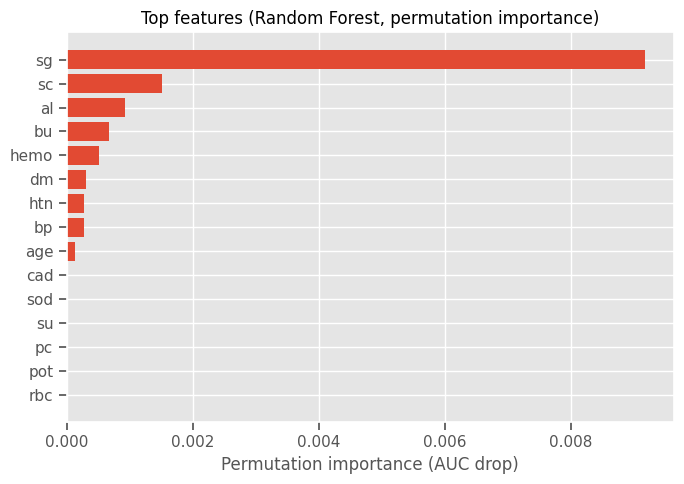

In [83]:
import matplotlib.pyplot as plt

top = perm_imp.head(15).sort_values("Perm_Importance_Mean")
plt.figure(figsize=(7,5))
plt.barh(top["Variable"], top["Perm_Importance_Mean"])
plt.xlabel("Permutation importance (AUC drop)")
plt.title("Top features (Random Forest, permutation importance)")
plt.tight_layout()
plt.show()


A post-hoc feature relevance analysis was performed to identify variables most strongly associated with CKD status, using three complementary approaches: ANOVA F-statistics, mutual information, and Random Forest feature importance.

Across all methods, anemia-related parameters (hemoglobin, packed cell volume, red blood cell count) consistently ranked as the most informative features, highlighting anemia as a dominant systemic manifestation of CKD. Serum creatinine and urinalysis markers (specific gravity and albuminuria) followed closely, reflecting both functional impairment and structural renal damage.

Cardiometabolic comorbidities such as hypertension and diabetes mellitus showed moderate but stable relevance, consistent with their role as risk factors rather than direct disease markers. Electrolyte and metabolic variables displayed weaker associations, indicating secondary systemic effects.

The strong agreement across statistical, information-theoretic, and model-based criteria supports the biological plausibility of the unsupervised clustering results and confirms that the intrinsic structure of the dataset aligns with established clinical knowledge of CKD.

## Logistic regression

We fitted a logistic regression model as an interpretable supervised approach to discriminate CKD from non-CKD cases and to provide a benchmark for comparison with non-linear models. A pipeline including feature standardisation and class weighting was used to prevent data leakage and to account for class imbalance. Model performance was evaluated using the area under the receiver operating characteristic curve (ROC AUC) and standard classification metrics.

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

X = df2[feature_cols]
y = (df2["status"].str.lower() == "ckd").astype(int)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        penalty="l2",
        C=1.0,
        class_weight="balanced",
        max_iter=500,
        solver="lbfgs"
    ))
])

pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))


ROC AUC: 1.0
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.97      0.98        62

    accuracy                           0.98       100
   macro avg       0.97      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



The logistic regression model showed near-perfect performance (ROC AUC = 1.0; accuracy = 98%), with high precision and recall across both classes. Such results indicate strong class separability in the dataset, which is consistent with the presence of classical diagnostic and post-diagnostic clinical variables and should therefore be interpreted as confirmatory discrimination rather than evidence of true predictive generalisability.

We inspected feature-wise median values by disease status to identify the main drivers of group separation and to contextualise the model’s near-perfect discrimination.

In [85]:
for c in feature_cols:
    print(c, df2.groupby("status")[c].median())


age status
ckd       0.392156
notckd   -0.432291
Name: age, dtype: float64
bp status
ckd       0.407224
notckd   -0.409254
Name: bp, dtype: float64
bgr status
ckd       0.198154
notckd   -0.426045
Name: bgr, dtype: float64
bu status
ckd       0.294379
notckd   -0.424624
Name: bu, dtype: float64
sc status
ckd       0.486978
notckd   -0.790542
Name: sc, dtype: float64
sod status
ckd      -0.359943
notckd    0.457863
Name: sod, dtype: float64
pot status
ckd      -0.038746
notckd    0.230389
Name: pot, dtype: float64
hemo status
ckd      -0.440746
notckd    0.951802
Name: hemo, dtype: float64
pcv status
ckd      -0.643825
notckd    0.954239
Name: pcv, dtype: float64
wbcc status
ckd       0.287574
notckd   -0.280496
Name: wbcc, dtype: float64
rbcc status
ckd      -0.398337
notckd    0.853674
Name: rbcc, dtype: float64
sg status
ckd       0.50
notckd    0.75
Name: sg, dtype: float64
al status
ckd       0.2
notckd    0.0
Name: al, dtype: float64
su status
ckd       0.0
notckd    0.0
Name: su,

The near-perfect discrimination observed when including classical renal function and comorbidity variables reflects the post-diagnostic nature of the dataset rather than genuine predictive performance.

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

X = df2[feature_cols].copy()
y = (df2["status"].str.lower() == "ckd").astype(int)

pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=5000,
        C=0.1  # força més sparsity (pots provar 0.01–1)
    ))
])

pipe_l1.fit(X, y)

# extreure coeficients
coefs = pipe_l1.named_steps["lr"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()


selected = coef_df[coef_df["coef"] != 0].sort_values("abs_coef", ascending=False)

print("Number of selected (non-zero) features:", selected.shape[0])
print(selected[["feature", "coef"]].to_string(index=False))


Number of selected (non-zero) features: 8
feature      coef
   hemo -1.245312
     sg -1.127326
     al  0.462756
     dm  0.447143
     sc  0.436011
    pcv -0.369643
    htn  0.205612
    rbc  0.019728


Using L1-regularised logistic regression, only eight variables were retained with non-zero coefficients, indicating that a small subset of features is sufficient to explain class separation. The selected variables mainly correspond to classical clinical and post-diagnostic markers of CKD, including `hemo`, `pcv`, `sc`, `sg`, `al` and major comorbidities as `dm` and `htn`. 

This confirms that the near-perfect discrimination observed in previous models is driven by a limited number of clinically defining variables rather than a broad multivariate signature.

To avoid trivial discrimination driven by post-diagnostic variables, we restricted the analysis to a subset of early, non-diagnostic clinical features. An L1-regularised logistic regression model was then fitted to identify the minimal set of early predictors contributing to CKD discrimination.

In [87]:
early_vars = ["age","bp","bgr","sod","sg","al","wbcc"]

X_early = df2[early_vars]
y = (df2["status"].str.lower() == "ckd").astype(int)

pipe_l1_early = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=5000,
        C=0.5
    ))
])

pipe_l1_early.fit(X_early, y)

coefs = pipe_l1_early.named_steps["lr"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature": X_early.columns,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

print(coef_df)


  feature      coef  abs_coef
5      al  2.868540  2.868540
4      sg -2.623126  2.623126
3     sod -1.245545  1.245545
6    wbcc  0.574549  0.574549
1      bp  0.528870  0.528870
2     bgr  0.335079  0.335079
0     age  0.301026  0.301026


When restricting the analysis to early and non-diagnostic variables, L1-regularised logistic regression retained seven predictors with non-zero coefficients. The strongest effects were observed for `al` and `sg`, followed by `sod`, `wbcc`, `bp`, `bg` and `age`. 

Unlike models including classical renal function markers, this reduced model reflects early physiological and metabolic alterations associated with CKD rather than post-diagnostic consequences.